In [1]:
!python --version

Python 3.9.19


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

from src.results_loaders import CLadder, ProntoQA, HelmResultsLoader, EvalsResultsLoader
from src.utils import load_with_conditions, save_dataframe, Cohen_correction, initialize_instance
import numpy as np

from tqdm.notebook import tqdm

# enable reloading of modules
%load_ext autoreload
%autoreload 2

/home/lorenzo/venv/recog-LLM_capabilities/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## How does the ability of predicting ground truth affect LLM performance

First list the various things for HELM, evals and the datasets with specialised loaders.

In [2]:
helm_list = [('legalbench', 'abercrombie'), ('legalbench', 'corporate_lobbying'), ('legalbench', 'function_of_decision_section'), ('legalbench', 'proa'), ('legalbench', 'international_citizenship_questions')]

In [3]:
evals_list = ['fantasy_reasoning',
 'neubaroco',
 'moral_permissibility',
 'causal_judgment',
 'metaphor_boolean',
 'commonsense_qa_2',
 'space_nli',
 'anli',
 'art',
 'wanli',
 'babi_task_16',
 'formal_fallacies_syllogisms_negation']

In [4]:
total_list = [(EvalsResultsLoader, eval) for eval in evals_list] + [(HelmResultsLoader, scenario, subscenario) for scenario, subscenario in helm_list] + [(CLadder,), (ProntoQA,)]

### Stratify the performance of LLMs according to if the ngrams approach predicted the ground truth correctly or not

Loop over all datasets, then for any of them extract the prediction of performance on the ngrams, and stratify the performance of the various LLMs on the test dataset

I do this only for the datasets where the ground truth is a "choice".

In [5]:
# now need to implement computation of random guesses using the observed proportions of real labels and the predictions
def compute_random_guesses(labels, predictions):
    assert len(labels) == len(predictions)
    # Assuming labels and predictions are NumPy arrays
    labels_series = pd.Series(labels)
    predictions_series = pd.Series(predictions)

    # Use Cohen's approach: count the number of times each label appears in the predictions and the labels
    label_counts = labels_series.value_counts()
    prediction_counts = predictions_series.value_counts()    # union of the two sets of labels
    total_set_labels = set(label_counts.index) | set(prediction_counts.index)
    # compute the random guess
    random_guess = 0
    for label in total_set_labels:
        if label not in label_counts or label not in prediction_counts:
            random_guess += 0
        else:
            random_guess += label_counts[label] * prediction_counts[label]
    random_guess /= len(labels) ** 2

    return random_guess

In [6]:
filename = "results/ground_truth_prediction_performance.pkl"
primal_performance_df = load_with_conditions(filename)

Loading existing dataframe.


In [7]:
primal_performance_df.shape

(1026, 9)

In [8]:
best_predictive_method_per_feature_primal = primal_performance_df.groupby(["dataset", "features"]).apply(lambda x: x[x.Accuracy_val == x.Accuracy_val.max()]).reset_index(drop=True)
# if there are more than one entry with the same accuracy for each ["dataset", "features"] combination, then pick the first one; also keep the dataset and features columns
best_predictive_method_per_feature_primal = best_predictive_method_per_feature_primal.groupby(["dataset", "features"]).first().reset_index()

Compute Cohen correction for the predictive performance of the simple methods

In [9]:
best_predictive_method_per_feature_primal.shape

(285, 9)

In [10]:
best_predictive_method_per_feature_primal.columns

Index(['dataset', 'features', 'predictive_method', 'trained_classifier',
       'Accuracy_val', 'Accuracy_test', 'instance_level_predictions_val',
       'instance_level_predictions_test', 'group'],
      dtype='object')

In [11]:
# Count how many different values per row in the "instance_level_predictions_test" column
best_predictive_method_per_feature_primal["instance_level_predictions_test"].apply(lambda x: 0 if len(x.shape)==0 else len(set(x))).value_counts()

2    123
3     53
1     42
0     38
4     16
7     13
Name: instance_level_predictions_test, dtype: int64

The following computes the random guesses, that are used for the Cohen correction.

In [19]:
# add two empty columns to the dataframe: cohen_correction_n_choices and cohen_correction_proportions
best_predictive_method_per_feature_primal["cohen_correction_n_choices"] = np.nan
best_predictive_method_per_feature_primal["cohen_correction_proportions"] = np.nan
# loop over all datasets
for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group = initialize_instance(dataset)

    # Split the dataset
    train_df, val_df, test_df = instance.train_val_test_split(discard_na_rows=False, rng=np.random.RandomState(42), train_size=0.6, val_size=0.2)

    primal_train_labels = train_df[ideal_col_name]
    primal_test_labels = test_df[ideal_col_name]

    # Encode the labels
    label_encoder = LabelEncoder()
    primal_train_labels_encoded = label_encoder.fit_transform(primal_train_labels)
    primal_test_labels_encoded = label_encoder.transform(test_df[ideal_col_name])

    # extract the indices of the dataframe with that dataset:
    indices = best_predictive_method_per_feature_primal[best_predictive_method_per_feature_primal["dataset"] == dataset_name].index
    # loop over those rows:
    for i in indices:
        if best_predictive_method_per_feature_primal.loc[i, "predictive_method"] in ["most_likely_answer", "random_guess"]:
            continue
        # extract the predictions from the best_predictive_method_per_feature_primal dataframe
        instance_level_predictions = best_predictive_method_per_feature_primal.loc[i, "instance_level_predictions_test"]
        # extract the labels
        # compute the random guess
        random_guess_n_choices = 1 / len(primal_test_labels.unique())
        random_guess_proportion = compute_random_guesses(primal_test_labels_encoded, instance_level_predictions)
        # now compute the Cohen's correction with the two random guess values
        cohen_correction_n_choices = Cohen_correction(best_predictive_method_per_feature_primal.loc[i, "Accuracy_test"], random_guess_n_choices)
        cohen_correction_proportion = Cohen_correction(best_predictive_method_per_feature_primal.loc[i, "Accuracy_test"], random_guess_proportion)
        # update the dataframe
        best_predictive_method_per_feature_primal.loc[i, "cohen_correction_n_choices"] = cohen_correction_n_choices
        best_predictive_method_per_feature_primal.loc[i, "cohen_correction_proportions"] = cohen_correction_proportion


  0%|          | 0/19 [00:00<?, ?it/s]

/content/gdrive/MyDrive/BenchmarkValidity/src/results_loaders.py:1887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_dict_cladder[llm]["prompt"] = results_dict_cladder[llm]["prompt"].apply(


In [20]:
best_predictive_method_per_feature_primal["cohen_correction_n_choices"]

,cohen_correction_n_choices
0,0.134044
1,0.122827
2,0.134044
3,0.122827
4,0.098149
...,...
280,0.205000
281,0.205000
282,NaN
283,NaN


In [27]:
features_list =  ['1-grams_presence',
 '1-grams_presence_gpt2',
 '1-grams_simple_frequency',
 '1-grams_simple_frequency_gpt2',
 '1-grams_tfidf',
 '1-grams_tfidf_gpt2',
 '2-grams_presence',
 '2-grams_presence_gpt2',
 '2-grams_simple_frequency',
 '2-grams_simple_frequency_gpt2',
 '2-grams_tfidf',
 '2-grams_tfidf_gpt2',
 'readability_diversity_metrics']

In [21]:
stratified_success_file = "results/stratified_successes.csv"

The following computes the stratified performance (in terms of Cohen correction) stratified for the cases where the simple methods correctly or incorrectly predicted success.

In [26]:
stratified_successes = []
for features in features_list:
    # Loop over all datasets
    for dataset in tqdm(total_list):
        instance, dataset_name, ideal_col_name, group = initialize_instance(dataset)

        # Split the dataset
        train_df, val_df, test_df = instance.train_val_test_split(discard_na_rows=False, rng=np.random.RandomState(42), train_size=0.6, val_size=0.2)

        primal_train_labels = train_df[ideal_col_name]
        primal_test_labels = test_df[ideal_col_name]

        # Encode the labels
        label_encoder = LabelEncoder()
        primal_train_labels_encoded = label_encoder.fit_transform(primal_train_labels)
        primal_test_labels_encoded = label_encoder.transform(test_df[ideal_col_name])

        # extract the predictions from the best_predictive_method_per_feature_primal dataframe
        best_predictive_method_feature_primal = best_predictive_method_per_feature_primal[best_predictive_method_per_feature_primal["dataset"] == dataset_name]
        best_predictive_method_feature_primal = best_predictive_method_feature_primal[best_predictive_method_feature_primal["features"] == features]
        instance_level_predictions = best_predictive_method_feature_primal["instance_level_predictions_test"].values[0]
        instance_level_correct = instance_level_predictions == primal_test_labels_encoded

        random_guess_n_choices = 1 / len(primal_test_labels.unique())

        # Stratify the performance of the various LLMs on the test dataset
        for llm in instance.llms:
            llm_success = test_df[f"Success_{llm}"]
            llm_average_success_on_successfully_predicted = llm_success[instance_level_correct].mean()
            llm_average_success_on_unsuccessfully_predicted = llm_success[~instance_level_correct].mean()

            # random_guess_proportion_successfully_predicted = compute_random_guesses(primal_test_labels[instance_level_correct], instance_level_predictions[instance_level_correct])
            # random_guess_proportion_unsuccessfully_predicted = compute_random_guesses(primal_test_labels[~instance_level_correct], instance_level_predictions[~instance_level_correct])
            # now compute the Cohen's correction with the two random guess values, for the two subsets
            cohen_correction_n_choices_on_successfully_predicted = Cohen_correction(llm_average_success_on_successfully_predicted, random_guess_n_choices)
            cohen_correction_n_choices_on_unsuccessfully_predicted = Cohen_correction(llm_average_success_on_unsuccessfully_predicted, random_guess_n_choices)

            stratified_successes.append({"llm": llm, "dataset": dataset_name, "average_success": llm_average_success_on_successfully_predicted, "cohen_correction_n_choices": cohen_correction_n_choices_on_successfully_predicted, "on": "successfully_predicted", "features": features})
            stratified_successes.append({"llm": llm, "dataset": dataset_name, "average_success": llm_average_success_on_unsuccessfully_predicted, "cohen_correction_n_choices": cohen_correction_n_choices_on_unsuccessfully_predicted, "on": "unsuccessfully_predicted", "features": features})

        # save
        stratified_successes_df = pd.DataFrame(stratified_successes)
        save_dataframe(stratified_success_file, stratified_successes_df)


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

/content/gdrive/MyDrive/BenchmarkValidity/src/results_loaders.py:1887: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_dict_cladder[llm]["prompt"] = results_dict_cladder[llm]["prompt"].apply(


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Now do the same but without XGBoost (as that is a complex algorithm that LLMs may be unable to fully capture):

In [212]:
primal_performance_df_no_xgboost = primal_performance_df[primal_performance_df["predictive_method"] != "XGBoost"]

best_predictive_method_per_feature_primal_no_xgboost = primal_performance_df_no_xgboost.groupby(["dataset", "features"]).apply(lambda x: x[x.Accuracy_val == x.Accuracy_val.max()]).reset_index(drop=True)
# if there are more than one entry with the same accuracy for each ["dataset", "features"] combination, then pick the first one; also keep the dataset and features columns
best_predictive_method_per_feature_primal_no_xgboost = best_predictive_method_per_feature_primal_no_xgboost.groupby(["dataset", "features"]).first().reset_index()

In [213]:
stratified_success_file = "results/stratified_successes_no_xgboost.csv"

In [214]:
stratified_successes_no_xgboost = []
for features in features_list:
    # Loop over all datasets
    for dataset in tqdm(total_list):
        instance, dataset_name, ideal_col_name, group = initialize_instance(dataset)

        # Split the dataset
        train_df, val_df, test_df = instance.train_val_test_split(discard_na_rows=False, rng=np.random.RandomState(42), train_size=0.6, val_size=0.2)

        primal_train_labels = train_df[ideal_col_name]
        primal_test_labels = test_df[ideal_col_name]

        # Encode the labels
        label_encoder = LabelEncoder()
        primal_train_labels_encoded = label_encoder.fit_transform(primal_train_labels)
        primal_test_labels_encoded = label_encoder.transform(test_df[ideal_col_name])

        # extract the predictions from the best_predictive_method_per_feature_primal dataframe
        best_predictive_method_feature_primal = best_predictive_method_per_feature_primal_no_xgboost[best_predictive_method_per_feature_primal_no_xgboost["dataset"] == dataset_name]
        best_predictive_method_feature_primal = best_predictive_method_feature_primal[best_predictive_method_feature_primal["features"] == features]
        instance_level_predictions = best_predictive_method_feature_primal["instance_level_predictions_test"].values[0]
        instance_level_correct = instance_level_predictions == primal_test_labels_encoded

        random_guess_n_choices = 1 / len(primal_test_labels.unique())

        # Stratify the performance of the various LLMs on the test dataset
        for llm in instance.llms:
            llm_success = test_df[f"Success_{llm}"]
            llm_average_success_on_successfully_predicted = llm_success[instance_level_correct].mean()
            llm_average_success_on_unsuccessfully_predicted = llm_success[~instance_level_correct].mean()

            # random_guess_proportion_successfully_predicted = compute_random_guesses(primal_test_labels[instance_level_correct], instance_level_predictions[instance_level_correct])
            # random_guess_proportion_unsuccessfully_predicted = compute_random_guesses(primal_test_labels[~instance_level_correct], instance_level_predictions[~instance_level_correct])
            # now compute the Cohen's correction with the two random guess values, for the two subsets
            cohen_correction_n_choices_on_successfully_predicted = Cohen_correction(llm_average_success_on_successfully_predicted, random_guess_n_choices)
            cohen_correction_n_choices_on_unsuccessfully_predicted = Cohen_correction(llm_average_success_on_unsuccessfully_predicted, random_guess_n_choices)

            stratified_successes_no_xgboost.append({"llm": llm, "dataset": dataset_name, "average_success": llm_average_success_on_successfully_predicted, "cohen_correction_n_choices": cohen_correction_n_choices_on_successfully_predicted, "on": "successfully_predicted", "features": features})
            stratified_successes_no_xgboost.append({"llm": llm, "dataset": dataset_name, "average_success": llm_average_success_on_unsuccessfully_predicted, "cohen_correction_n_choices": cohen_correction_n_choices_on_unsuccessfully_predicted, "on": "unsuccessfully_predicted", "features": features})

        # save
        stratified_successes_no_xgboost_df = pd.DataFrame(stratified_successes_no_xgboost)
        save_dataframe(stratified_success_file, stratified_successes_no_xgboost_df)


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

## Plots showing the Cohen corrected stratified performance, for each LLM and dataset pair 

The accuracy of the simple classifier has two available correction (proportions and n_choices), while the accuracy of LLMs has the n_choices one only. Make the plots with that one for now.

Load the file:

In [30]:
stratified_successes_df = load_with_conditions(stratified_success_file)

Loading existing dataframe.


In [31]:
stratified_successes_df.columns

Index(['llm', 'dataset', 'average_success', 'cohen_correction_n_choices', 'on',
       'features'],
      dtype='object')

In [32]:
pivoted_table = stratified_successes_df.pivot_table(index=["dataset", "llm", "features"], columns="on", values="cohen_correction_n_choices")
pivoted_table = pivoted_table.reset_index()
pivoted_table["cohen_correction_difference"] = pivoted_table["successfully_predicted"] - pivoted_table["unsuccessfully_predicted"]
pivoted_table

on,dataset,llm,features,successfully_predicted,unsuccessfully_predicted,cohen_correction_difference
0,CLadder,davinci,1-grams_presence,0.080119,-0.015544,0.095663
1,CLadder,davinci,1-grams_presence_gpt2,0.082917,-0.017903,0.100820
2,CLadder,davinci,1-grams_simple_frequency,0.080119,-0.015544,0.095663
3,CLadder,davinci,1-grams_simple_frequency_gpt2,0.082917,-0.017903,0.100820
4,CLadder,davinci,1-grams_tfidf,0.105209,-0.042289,0.147498
...,...,...,...,...,...,...
4688,wanli,text-davinci-003,2-grams_simple_frequency,0.058140,0.381579,-0.323439
4689,wanli,text-davinci-003,2-grams_simple_frequency_gpt2,0.090426,0.377358,-0.286933
4690,wanli,text-davinci-003,2-grams_tfidf,-0.340426,0.759434,-1.099859
4691,wanli,text-davinci-003,2-grams_tfidf_gpt2,-0.228723,0.660377,-0.889101


The following scatter plot shows, for each dataset and LLM, the performance of the LLM on the two splits according to the predictions of the simple model; one panel per simple feature.

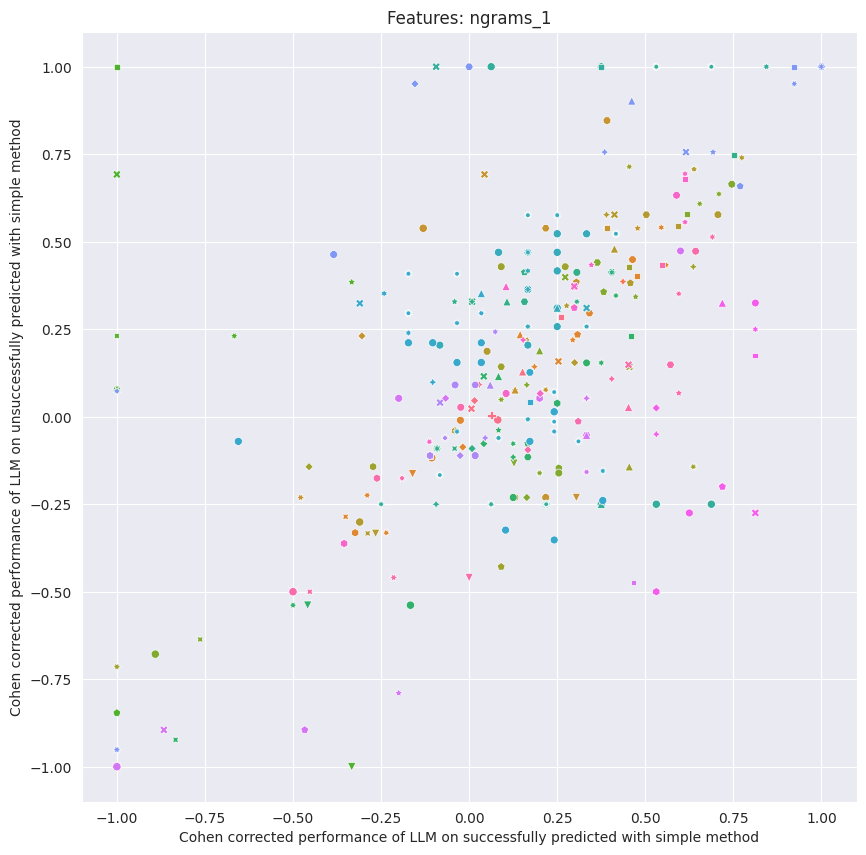

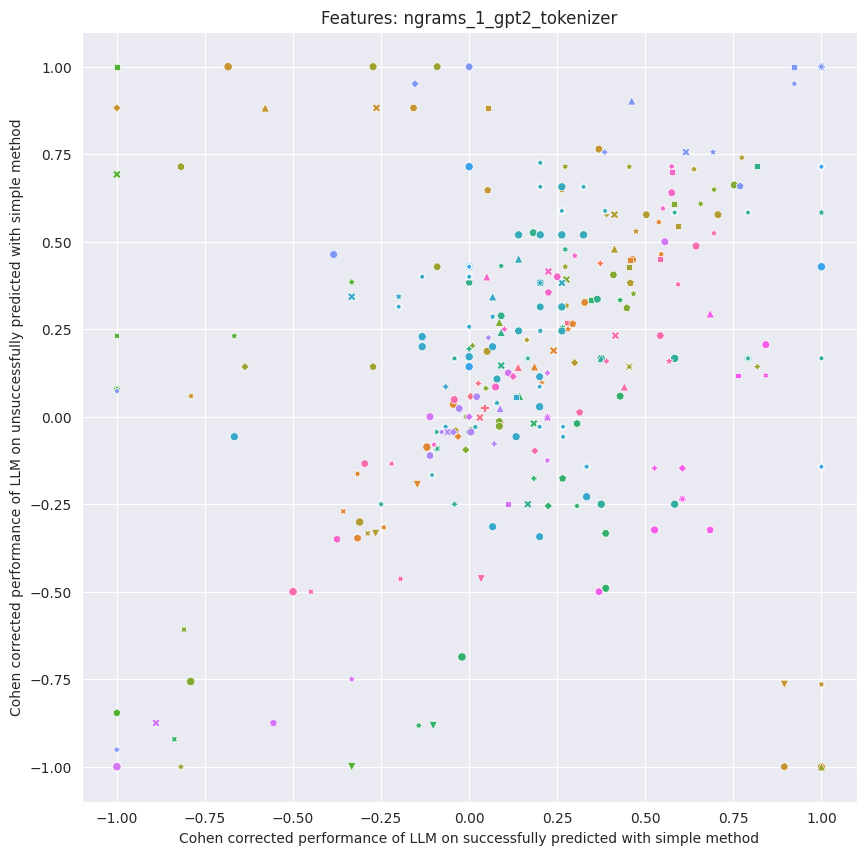

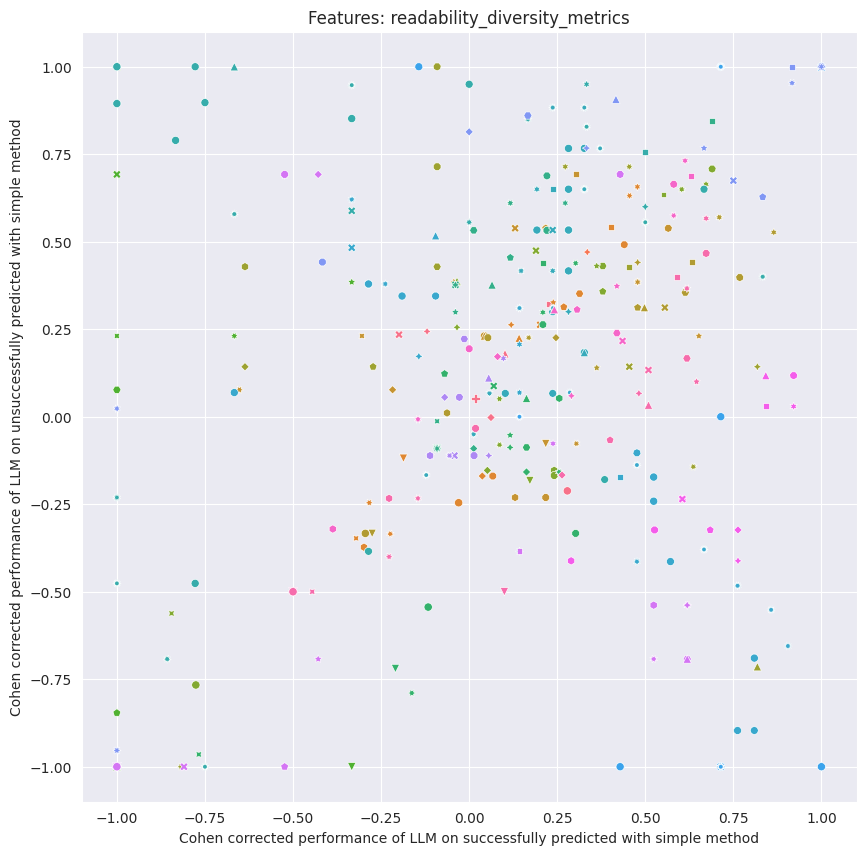

In [ ]:
for features in features_list:
    pivoted_table_features = pivoted_table[pivoted_table["features"] == features]
    # plot a scatterplot of the successfully vs unsuccessfully predicted, where colors=dataset and markers=llm
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=pivoted_table_features, x="unsuccessfully_predicted", y="successfully_predicted", hue="dataset", style="llm")
    # set title
    plt.title(f"Features: {features}")
    plt.xlabel("Cohen corrected performance of LLM on successfully predicted with simple method")
    plt.ylabel("Cohen corrected performance of LLM on unsuccessfully predicted with simple method")
    # hide legend
    plt.legend().remove()
    plt.show()

In [ ]:
for features in features_list:
    pivoted_table_features = pivoted_table[pivoted_table["features"] == features]
    print(f"Features: {features}")
    print(pivoted_table_features["cohen_correction_difference"].describe())
    print()

Features: ngrams_1
count    346.000000
mean      -0.009638
std        0.404932
min       -1.087500
25%       -0.154030
50%        0.000000
75%        0.129221
max        2.000000
Name: cohen_correction_difference, dtype: float64

Features: ngrams_1_gpt2_tokenizer
count    376.000000
mean       0.018250
std        0.503272
min       -2.000000
25%       -0.130936
50%        0.000000
75%        0.154346
max        2.000000
Name: cohen_correction_difference, dtype: float64

Features: readability_diversity_metrics
count    376.000000
mean       0.001572
std        0.643145
min       -2.000000
25%       -0.205585
50%        0.000000
75%        0.283287
max        2.000000
Name: cohen_correction_difference, dtype: float64



Plot the differences against the Cohen-corrected accuracy of the methods based on simple features

P-values for features ngrams_1:
 const                        NaN
cohen_correction_n_choices   NaN
dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


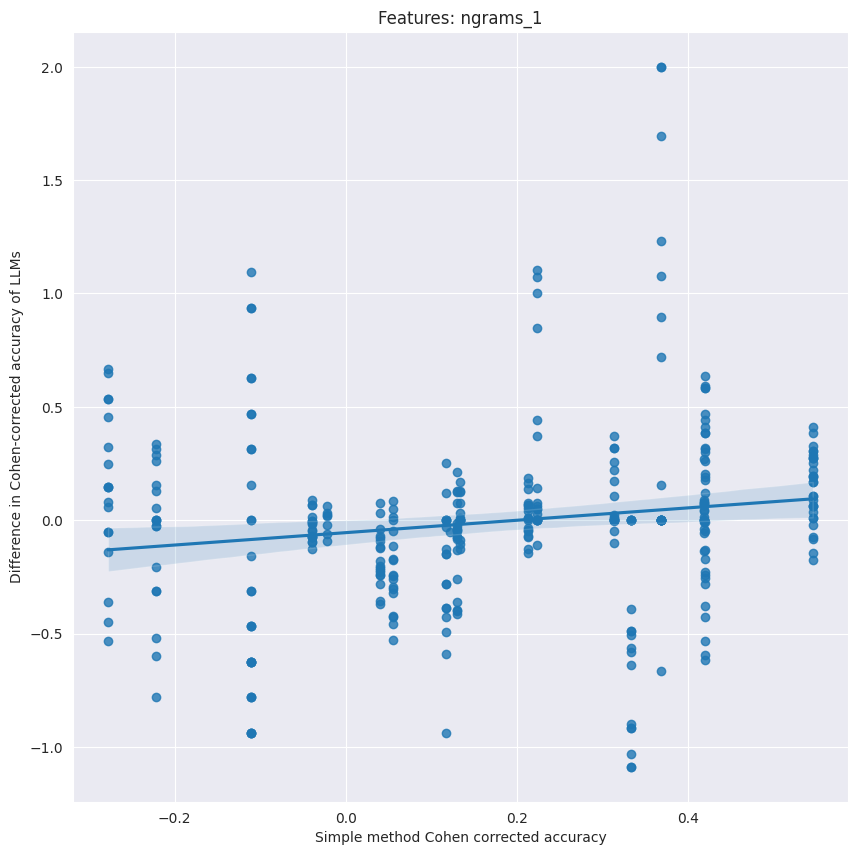

P-values for features ngrams_1_gpt2_tokenizer:
 const                        NaN
cohen_correction_n_choices   NaN
dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


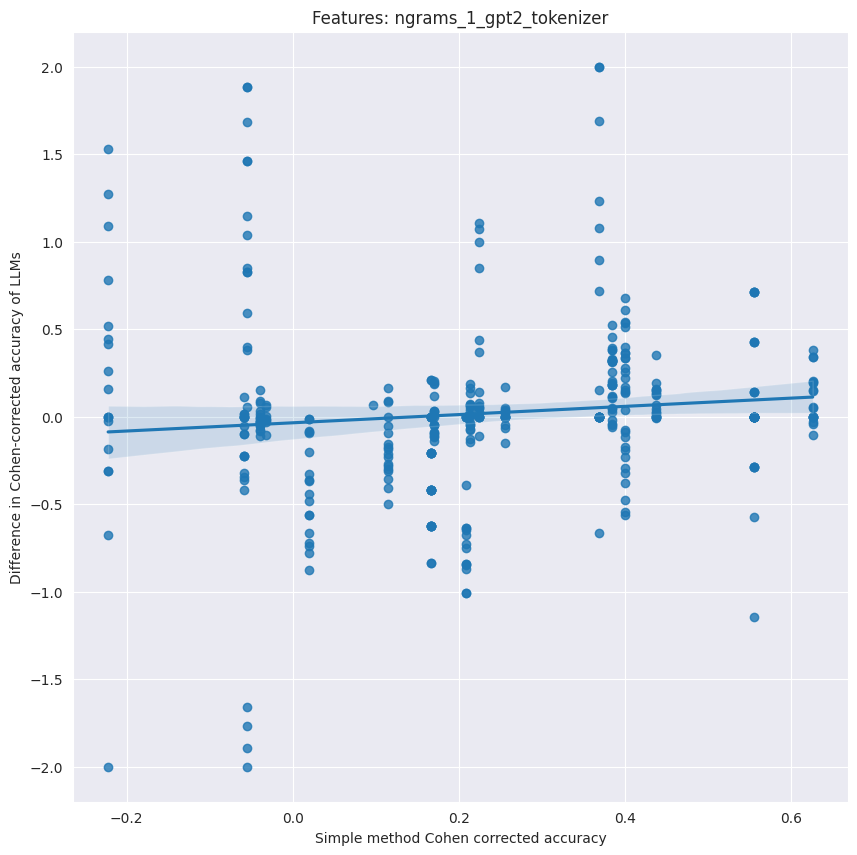

P-values for features readability_diversity_metrics:
 const                        NaN
cohen_correction_n_choices   NaN
dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


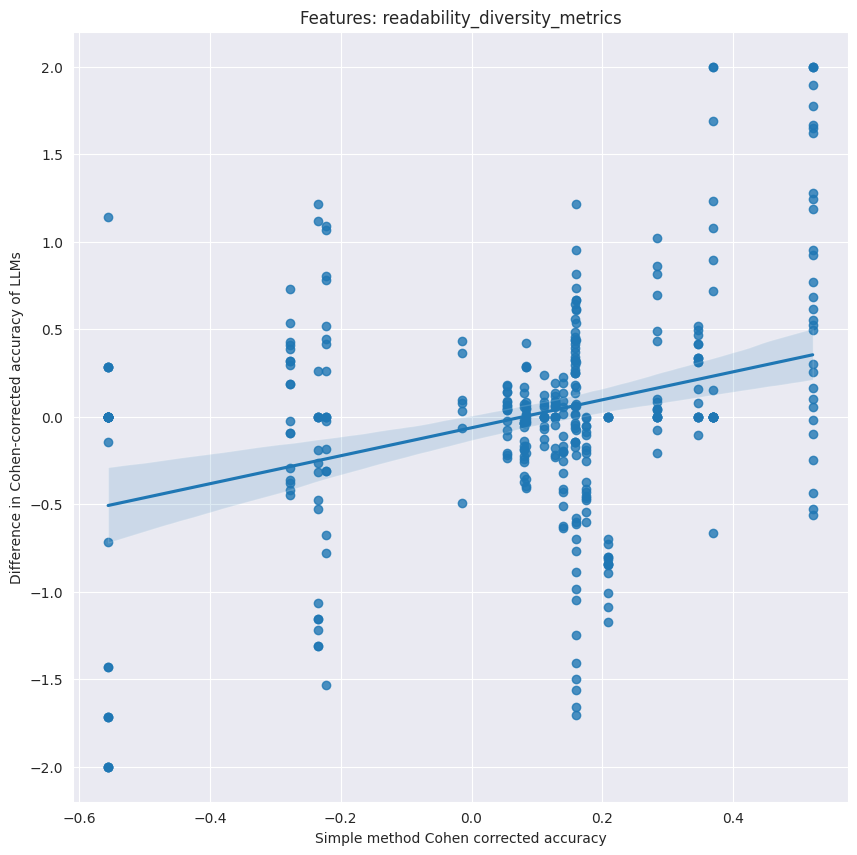

In [ ]:
for features in features_list:

    best_predictive_method_per_feature_primal_feature = best_predictive_method_per_feature_primal[best_predictive_method_per_feature_primal["features"] == features]
    best_predictive_method_per_feature_primal_feature = best_predictive_method_per_feature_primal_feature[["dataset", "cohen_correction_n_choices"]]
    final_table = pd.merge(pivoted_table, best_predictive_method_per_feature_primal_feature, on="dataset", how="left")

    final_table = final_table[final_table["features"] == features]

    # Perform regression analysis using statsmodels
    X = sm.add_constant(final_table["cohen_correction_n_choices"])  # Adds a constant term to the predictor
    model = sm.OLS(final_table["cohen_correction_difference"], X).fit()

    # Extract p-values
    p_values = model.pvalues
    print(f"P-values for features {features}:\n", p_values)

    # scatterplot of the accuracy of the ngrams vs the difference
    plt.figure(figsize=(10, 10))
    # sns.boxplot(data=final_table, x="difference", y="Accuracy_test", hue="llm")
    #sns.scatterplot(data=final_table, x="Accuracy_test", y="difference", hue="llm")
    sns.regplot(data=final_table, x="cohen_correction_n_choices", y="cohen_correction_difference")
    plt.xlabel("Simple method Cohen corrected accuracy")
    plt.ylabel("Difference in Cohen-corrected accuracy of LLMs")
    # set title
    plt.title(f"Features: {features}")
    # switch off legend
    plt.legend().remove()
    plt.show()

## Plots aggregating the performance of the LLMs on the various datasets
Keep only the features that have the highest validation accuracy for each dataset, and then see if there is an effect on the difference in LLM performance. 

In [16]:
def scatterplot_with_color(df, x_column, y_column, color_column, cmap='plasma', alpha=0.7):
    """
    Generates a scatterplot between two values in a DataFrame and colors the dots according to a third value
    using a unidimensional colormap.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    x_column (str): The column name to plot on the x-axis.
    y_column (str): The column name to plot on the y-axis.
    color_column (str): The column name whose values will determine the color of the dots.
    cmap (str): The colormap to use for coloring the points. Defaults to 'Blues' for a unidimensional colormap.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df[x_column], df[y_column], c=df[color_column], cmap=cmap, s=50, alpha=alpha)
    plt.colorbar(scatter, label=color_column)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'Scatterplot of {y_column} vs {x_column}\ncolored by {color_column}')
    # plt.show()
    
    return scatter


In [17]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

def corrected_paired_t_test(df, groups_col, alternative="greater"):
    # Assuming `stratified_successes_df` is the DataFrame containing your data

    # Initialize lists to store the results
    groups = []
    p_values = []
    test_statistics = []
    
    # Loop over each unique LLM and perform paired t-test
    for group in df[groups_col].unique():
        # Subset the dataframe by LLM
        group_data = df[df[groups_col] == group]
    
        # Perform paired t-test between the two columns for each LLM
        t_stat, p_val = stats.ttest_rel(
            group_data["Normalised LLM accuracy on successfully predicted split (Cohen correction)"],
            group_data["Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)"], 
            alternative=alternative  # our alternative hypothesis is that the former is larger than the latter
        )
        
        # Store the results
        groups.append(group)
        test_statistics.append(t_stat)
        p_values.append(p_val)
    
    # Create a DataFrame to store results
    results_df = pd.DataFrame({
        groups_col: groups,
        't_stat': test_statistics,
        'p_value': p_values
    })
    # drop na
    results_df = results_df.dropna()
    
    # Apply Benjamini-Hochberg correction for multiple comparisons
    rejected, pvals_corrected, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
    
    # Add the corrected p-values and rejection decision to the results DataFrame
    results_df['p_value_corrected'] = pvals_corrected
    results_df['significant'] = rejected
    
    return results_df

In [18]:
models_dict = {
    'davinci': 'openai/davinci',
    'gpt-3.5-turbo-0613': 'openai/gpt-3.5-turbo-0613',
    'gpt-4-1106-preview': 'openai/gpt-4-1106-preview',
    'text-davinci-001': 'openai/text-davinci-001',
    'text-davinci-002': 'openai/text-davinci-002',
    'text-davinci-003': 'openai/text-davinci-003',
    'ada': 'openai/ada',
    'babbage': 'openai/babbage',
    'curie': 'openai/curie',
    'gpt-3.5-turbo-0125': 'openai/gpt-3.5-turbo-0125',
    'gpt-3.5-turbo-0301': 'openai/gpt-3.5-turbo-0301',
    'gpt-3.5-turbo-1106': 'openai/gpt-3.5-turbo-1106',
    'gpt-4-0125-preview': 'openai/gpt-4-0125-preview',
    'gpt-4-0314': 'openai/gpt-4-0314',
    'gpt-4-0613': 'openai/gpt-4-0613',
    'text-ada-001': 'openai/text-ada-001',
    'text-babbage-001': 'openai/text-babbage-001',
    'text-curie-001': 'openai/text-curie-001',
    'llama007': 'meta/llama-1-7b'
}


In [19]:
filename = "results/ground_truth_prediction_performance.pkl"
primal_performance_df = load_with_conditions(filename)

Loading existing dataframe.


In [20]:
primal_performance_df.shape

(1026, 9)

Compute the overall LLM accuracy:

In [21]:
overall_LLM_accuracy = []

for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group = initialize_instance(dataset)

    train_df, val_df, test_df = instance.train_val_test_split(discard_na_rows=False, rng=np.random.RandomState(42), train_size=0.6, val_size=0.2)

    primal_labels = instance.results_df[ideal_col_name]
    
    random_guess_n_choices = 1 / len(primal_labels.unique())

    # Stratify the performance of the various LLMs on the test dataset
    for llm in instance.llms:
        llm_success = test_df[f"Success_{llm}"].mean()
        
        llm_success_Cohen_correction = Cohen_correction(llm_success, random_guess_n_choices)
        
        overall_LLM_accuracy.append({"LLM": llm, "Dataset": dataset_name, "Overall LLM accuracy": llm_success, "Normalised overall LLM accuracy (Cohen correction)": llm_success_Cohen_correction})
        
overall_LLM_accuracy_df = pd.DataFrame(overall_LLM_accuracy)    


  0%|          | 0/19 [00:00<?, ?it/s]

In [22]:
overall_LLM_accuracy_df.columns

Index(['LLM', 'Dataset', 'Overall LLM accuracy',
       'Normalised overall LLM accuracy (Cohen correction)'],
      dtype='object')

### Accuracy of the LLMs on the various datasets 

Make a violinplot showing the performance of the various LLMs on the various datasets

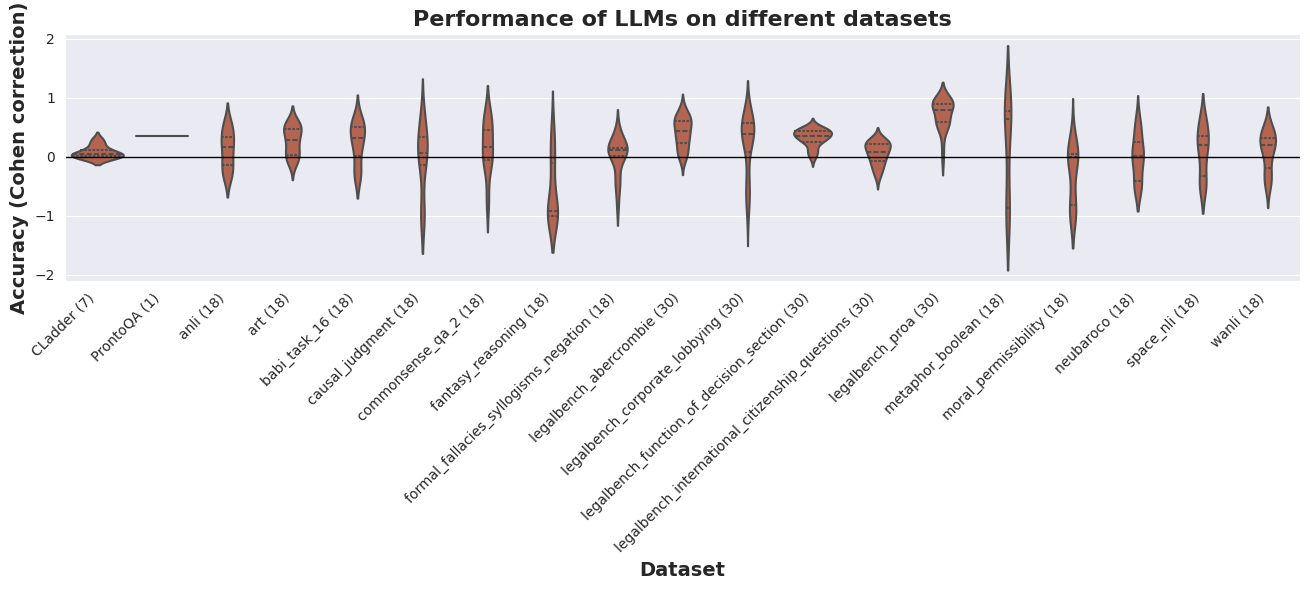

In [23]:
# make a violinplot
plt.figure(figsize=(20*2/3, 6))

# use the extremes of this colormap as colors:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# extract the two extreme values
cmap_min = cmap(-50)#np.inf)
cmap_max = cmap(250)#np.inf)

# sort by Dataset name
overall_LLM_accuracy_df = overall_LLM_accuracy_df.sort_values(by="Dataset")

# for the ticks, compute the number of LLMs tested with each dataset
llms_per_dataset = overall_LLM_accuracy_df.groupby("Dataset")["LLM"].nunique()
# add the number of LLMs tested with each dataset
ticks = []
for i, dataset in enumerate(overall_LLM_accuracy_df["Dataset"].unique()):
    ticks.append(f"{dataset} ({llms_per_dataset[dataset]})")
    
sns.violinplot(x='Dataset', y="Normalised overall LLM accuracy (Cohen correction)", data=overall_LLM_accuracy_df,
                inner='quartile', linewidth=1.5, color=cmap_max)
# sns.stripplot(x='Dataset', y="Normalised overall LLM accuracy (Cohen correction)", data=stratified_successes_df, color=cmap_max)

# rotate
plt.xticks(ticks=range(len(ticks)), labels=ticks, rotation=45, ha='right')   
# plt.xticks(rotation=45, ha='right')   

plt.xlabel("Dataset", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy (Cohen correction)", fontsize=14, fontweight='bold')
plt.title('Performance of LLMs on different datasets', fontsize=16, fontweight='bold')

# add horizontal line at 0
plt.axhline(y=0, color='k', lw=1)

# save with tight layout
plt.tight_layout()
plt.savefig("fig/LLM_accuracy_violinplot.png")
plt.savefig("fig/LLM_accuracy_violinplot.pdf")
plt.show()

### Table of LLMs and dataset

In [897]:
def map_llm_names(elem):
    if elem in models_dict:
        return models_dict[elem]
    else:
        return elem

# Step 1: Add a constant value column to indicate presence
overall_LLM_accuracy_df['presence'] = 1

# Step 2: Create the pivot table
pivot_df = overall_LLM_accuracy_df.pivot(index='LLM', columns='Dataset', values='presence')

# Step 3: Fill missing values with 0
pivot_df = pivot_df.fillna(0)

# convert the llm names
pivot_df = pivot_df.reset_index()

pivot_df["LLM"] = pivot_df["LLM"].apply(map_llm_names)

# sort by llms
pivot_df = pivot_df.sort_values(by="LLM")

# Convert the DataFrame to a LaTeX table with ticks and crosses
def df_to_latex_with_ticks_and_crosses(df):
    latex_str = df.to_latex(escape=True, index=False)
    latex_str = latex_str.replace('1.0', '\\textcolor{green}{\\ding{51}}')  # Green tick
    latex_str = latex_str.replace('0.0', '\\textcolor{red}{\\ding{55}}')    # Red cross
    return latex_str

# Generate the LaTeX table string
latex_table = df_to_latex_with_ticks_and_crosses(pivot_df)

# Add necessary LaTeX packages
latex_table = (
    "\\documentclass{article}\n"
    "\\usepackage{pifont}\n"
    "\\usepackage{xcolor}\n"
    "\\begin{document}\n"
    + latex_table +
    "\\end{document}"
)

# Save the LaTeX table to a file
with open("tab/llm_dataset_table.tex", "w") as f:
    f.write(latex_table)


/tmp/ipykernel_35033/881964288.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = df.to_latex(escape=True, index=False)


### Aggregated plots, stratified across correctly and uncorrectly predicted splits, with XGBoost

For each dataset, keep the best predictive method and features

In [431]:
primal_performance_df_no_baselines = primal_performance_df[~primal_performance_df["predictive_method"].isin(["most_likely_answer", "random_guess"])]

best_predictive_method_primal = primal_performance_df_no_baselines.groupby(["dataset"]).apply(lambda x: x[x.Accuracy_val == x.Accuracy_val.max()]).reset_index(drop=True)
# if there are more than one entry with the same accuracy for each ["dataset", "features"] combination, then pick the first one; also keep the dataset and features columns
best_predictive_method_primal = best_predictive_method_primal.groupby(["dataset"]).first().reset_index()

Compute Cohen correction for the predictive performance of the simple methods

In [432]:
# add two empty columns to the dataframe: cohen_correction_n_choices and cohen_correction_proportions
best_predictive_method_primal["cohen_correction_n_choices"] = np.nan
# best_predictive_method_primal["cohen_correction_proportions"] = np.nan
# loop over all datasets
for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group = initialize_instance(dataset)

    # Split the dataset
    train_df, val_df, test_df = instance.train_val_test_split(discard_na_rows=False, rng=np.random.RandomState(42), train_size=0.6, val_size=0.2)

    primal_train_labels = train_df[ideal_col_name]
    primal_test_labels = test_df[ideal_col_name]

    # Encode the labels
    label_encoder = LabelEncoder()
    primal_train_labels_encoded = label_encoder.fit_transform(primal_train_labels)
    primal_test_labels_encoded = label_encoder.transform(test_df[ideal_col_name])

    # extract the indices of the dataframe with that dataset:
    indices = best_predictive_method_primal[best_predictive_method_primal["dataset"] == dataset_name].index
    # loop over those rows:
    for i in indices:
        if best_predictive_method_primal.loc[i, "predictive_method"] in ["most_likely_answer", "random_guess"]:
            continue
        # extract the predictions from the best_predictive_method_primal dataframe
        instance_level_predictions = best_predictive_method_primal.loc[i, "instance_level_predictions_test"]
        # extract the labels
        # compute the random guess
        random_guess_n_choices = 1 / len(primal_test_labels.unique())
        # random_guess_proportion = compute_random_guesses(primal_test_labels_encoded, instance_level_predictions)
        # now compute the Cohen's correction with the two random guess values
        cohen_correction_n_choices = Cohen_correction(best_predictive_method_primal.loc[i, "Accuracy_test"], random_guess_n_choices)
        # cohen_correction_proportion = Cohen_correction(best_predictive_method_per_feature_primal.loc[i, "Accuracy_test"], random_guess_proportion)
        # update the dataframe
        best_predictive_method_primal.loc[i, "cohen_correction_n_choices"] = cohen_correction_n_choices
        # best_predictive_method_primal.loc[i, "cohen_correction_proportions"] = cohen_correction_proportion


  0%|          | 0/19 [00:00<?, ?it/s]

In [433]:
best_predictive_method_primal.columns

Index(['dataset', 'predictive_method', 'features', 'trained_classifier',
       'Accuracy_val', 'Accuracy_test', 'instance_level_predictions_val',
       'instance_level_predictions_test', 'group',
       'cohen_correction_n_choices'],
      dtype='object')

Table with the best features and predictive method

In [434]:
# make a latex table
print(best_predictive_method_primal[['dataset', 'predictive_method', 'features']].to_latex(index=False))

\begin{tabular}{lll}
\toprule
                                       dataset &            predictive\_method &                      features \\
\midrule
                                       CLadder &                      xgboost &      1-grams\_simple\_frequency \\
                                      ProntoQA &                      xgboost & 1-grams\_simple\_frequency\_gpt2 \\
                                          anli &   logistic\_regression\_l1\_c=1 & readability\_diversity\_metrics \\
                                           art &                      xgboost &                 1-grams\_tfidf \\
                                  babi\_task\_16 &                      xgboost &                 1-grams\_tfidf \\
                               causal\_judgment & logistic\_regression\_l1\_c=0.1 & readability\_diversity\_metrics \\
                              commonsense\_qa\_2 &   logistic\_regression\_l1\_c=1 & readability\_diversity\_metrics \\
                             

/tmp/ipykernel_35033/472138999.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_predictive_method_primal[['dataset', 'predictive_method', 'features']].to_latex(index=False))


In [435]:
# make ascii table
print(best_predictive_method_primal[['dataset', 'predictive_method', 'features']].to_string(index=False))

                                       dataset            predictive_method                      features
                                       CLadder                      xgboost      1-grams_simple_frequency
                                      ProntoQA                      xgboost 1-grams_simple_frequency_gpt2
                                          anli   logistic_regression_l1_c=1 readability_diversity_metrics
                                           art                      xgboost                 1-grams_tfidf
                                  babi_task_16                      xgboost                 1-grams_tfidf
                               causal_judgment logistic_regression_l1_c=0.1 readability_diversity_metrics
                              commonsense_qa_2   logistic_regression_l1_c=1 readability_diversity_metrics
                             fantasy_reasoning logistic_regression_l1_c=0.1      1-grams_simple_frequency
          formal_fallacies_syllogisms_negation

Load the stratified successes file 

In [436]:
stratified_success_file = "results/stratified_successes.csv"
# load 
stratified_successes_df = load_with_conditions(stratified_success_file)

Loading existing dataframe.


In [437]:
stratified_successes_df.shape

(9386, 6)

In [438]:
stratified_successes_df.columns

Index(['llm', 'dataset', 'average_success', 'cohen_correction_n_choices', 'on',
       'features'],
      dtype='object')

In [439]:
print(stratified_successes_df.isna().sum())

llm                             0
dataset                         0
average_success               266
cohen_correction_n_choices    266
on                              0
features                        0
dtype: int64


In [440]:
# drop the rows without na values
stratified_successes_df_na = stratified_successes_df[stratified_successes_df.isna().any(axis=1)]

In [441]:
stratified_successes_df_na.dataset.unique()

array(['legalbench_corporate_lobbying'], dtype=object)

That dataset has some na values because there was perfect predictability with n-grams -> no way to compute the performance of LLMs on the unsuccessfully predicted instances.

I need to discard this from the analysis then

In [442]:
stratified_successes_df = stratified_successes_df[stratified_successes_df["dataset"] != "legalbench_corporate_lobbying"]

Compute the difference of LLM performance in the cases successfully and unsuccessfully predicted by the simple method

In [443]:
stratified_successes_df = stratified_successes_df.pivot_table(index=["dataset", "llm", "features"], columns="on", values="cohen_correction_n_choices")
stratified_successes_df = stratified_successes_df.reset_index()
stratified_successes_df["cohen_correction_difference"] = stratified_successes_df["successfully_predicted"] - stratified_successes_df["unsuccessfully_predicted"]
stratified_successes_df.head()

on,dataset,llm,features,successfully_predicted,unsuccessfully_predicted,cohen_correction_difference
0,CLadder,davinci,1-grams_presence,0.080119,-0.015544,0.095663
1,CLadder,davinci,1-grams_presence_gpt2,0.082917,-0.017903,0.100820
2,CLadder,davinci,1-grams_simple_frequency,0.080119,-0.015544,0.095663
3,CLadder,davinci,1-grams_simple_frequency_gpt2,0.082917,-0.017903,0.100820
4,CLadder,davinci,1-grams_tfidf,0.105209,-0.042289,0.147498


In [444]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features', 'successfully_predicted',
       'unsuccessfully_predicted', 'cohen_correction_difference'],
      dtype='object', name='on')

In [445]:
# stratified_successes_df.drop(["successfully_predicted", "unsuccessfully_predicted"], axis=1, inplace=True)
stratified_successes_df = stratified_successes_df.rename(columns={"cohen_correction_difference": "Difference in normalised LLM accuracy (Cohen correction)", "successfully_predicted": "Normalised LLM accuracy on successfully predicted split (Cohen correction)", "unsuccessfully_predicted": "Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)"})

In [446]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)'],
      dtype='object', name='on')

In [447]:
stratified_successes_df.shape

(4303, 6)

For each dataset, I should only keep the rows where the features are the best one, ie those in the best_predictive_method_primal dataframe 
(notice that this the results in stratified_successes_df were already computed with the best predictive method)

The following cell merges the two dataframes and thus selects the best features for the stratified successes df.

In [448]:
stratified_successes_df = stratified_successes_df.merge(best_predictive_method_primal, on=["dataset", "features"])

In [449]:
stratified_successes_df.shape

(331, 14)

In [450]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)',
       'predictive_method', 'trained_classifier', 'Accuracy_val',
       'Accuracy_test', 'instance_level_predictions_val',
       'instance_level_predictions_test', 'group',
       'cohen_correction_n_choices'],
      dtype='object')

In [451]:
stratified_successes_df = stratified_successes_df.drop(columns=["Accuracy_val", "Accuracy_test", "instance_level_predictions_test", "group", "trained_classifier", "instance_level_predictions_val"])

In [452]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)',
       'predictive_method', 'cohen_correction_n_choices'],
      dtype='object')

In [453]:
rename_dict = {
    'llm': 'LLM',
    'dataset': 'Dataset',
    'average_success': 'average_success',
    'on': 'on',
    'features': 'Features',
    'cohen_correction_n_choices': 'Normalised n-grams accuracy (Cohen correction)',
    'successfully_predicted': 'Successfully predicted',
}

In [454]:
stratified_successes_df = stratified_successes_df.rename(columns=rename_dict)

In [455]:
stratified_successes_df.head()

,Dataset,LLM,Features,Normalised LLM accuracy on successfully predicted split (Cohen correction),Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction),Difference in normalised LLM accuracy (Cohen correction),predictive_method,Normalised n-grams accuracy (Cohen correction)
0,CLadder,davinci,1-grams_simple_frequency,0.080119,-0.015544,0.095663,xgboost,0.134044
1,CLadder,gpt-3.5-turbo-0613,1-grams_simple_frequency,-0.032641,0.059585,-0.092226,xgboost,0.134044
2,CLadder,gpt-4-1106-preview,1-grams_simple_frequency,0.268051,0.282383,-0.014332,xgboost,0.134044
3,CLadder,llama007,1-grams_simple_frequency,-0.046489,0.062176,-0.108665,xgboost,0.134044
4,CLadder,text-davinci-001,1-grams_simple_frequency,-0.018793,0.028497,-0.047291,xgboost,0.134044


Merge with the overall LLM accuracy dataframe:

In [456]:
stratified_successes_df = stratified_successes_df.merge(overall_LLM_accuracy_df, on=["LLM", "Dataset"])

In [457]:
stratified_successes_df.head()

,Dataset,LLM,Features,Normalised LLM accuracy on successfully predicted split (Cohen correction),Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction),Difference in normalised LLM accuracy (Cohen correction),predictive_method,Normalised n-grams accuracy (Cohen correction),Overall LLM accuracy,Normalised overall LLM accuracy (Cohen correction)
0,CLadder,davinci,1-grams_simple_frequency,0.080119,-0.015544,0.095663,xgboost,0.134044,0.519349,0.038699
1,CLadder,gpt-3.5-turbo-0613,1-grams_simple_frequency,-0.032641,0.059585,-0.092226,xgboost,0.134044,0.503646,0.007291
2,CLadder,gpt-4-1106-preview,1-grams_simple_frequency,0.268051,0.282383,-0.014332,xgboost,0.134044,0.637128,0.274257
3,CLadder,llama007,1-grams_simple_frequency,-0.046489,0.062176,-0.108665,xgboost,0.134044,0.500280,0.000561
4,CLadder,text-davinci-001,1-grams_simple_frequency,-0.018793,0.028497,-0.047291,xgboost,0.134044,0.500841,0.001683


In [458]:
stratified_successes_df.columns

Index(['Dataset', 'LLM', 'Features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)',
       'predictive_method', 'Normalised n-grams accuracy (Cohen correction)',
       'Overall LLM accuracy',
       'Normalised overall LLM accuracy (Cohen correction)'],
      dtype='object')

Plot of the difference between the LLM performance on the successfully and unsuccessfully predicted instances, against the Cohen-corrected accuracy of the n-grams

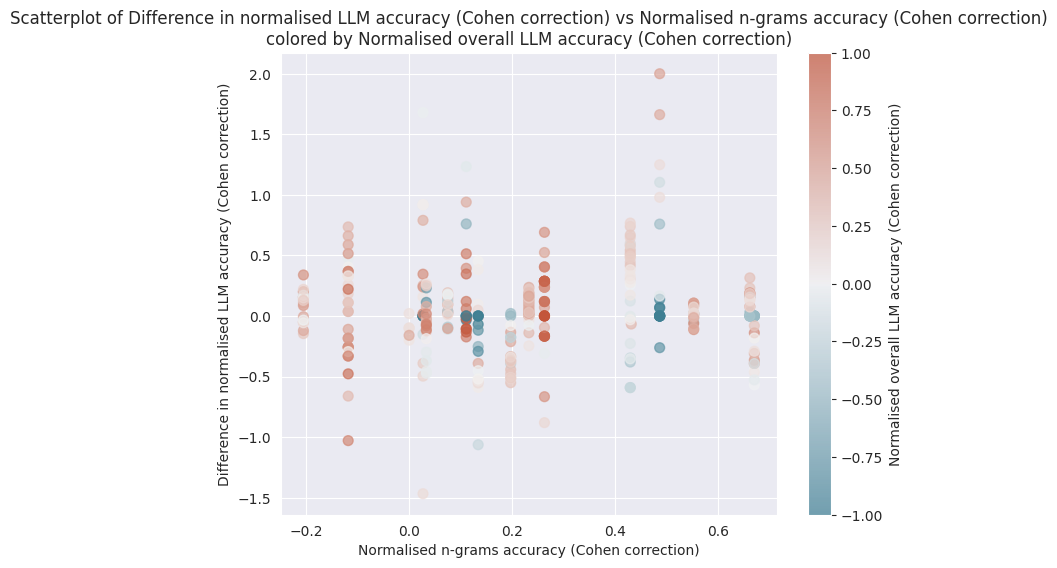

In [460]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

scatterplot_with_color(stratified_successes_df, "Normalised n-grams accuracy (Cohen correction)", "Difference in normalised LLM accuracy (Cohen correction)", "Normalised overall LLM accuracy (Cohen correction)", cmap=cmap)

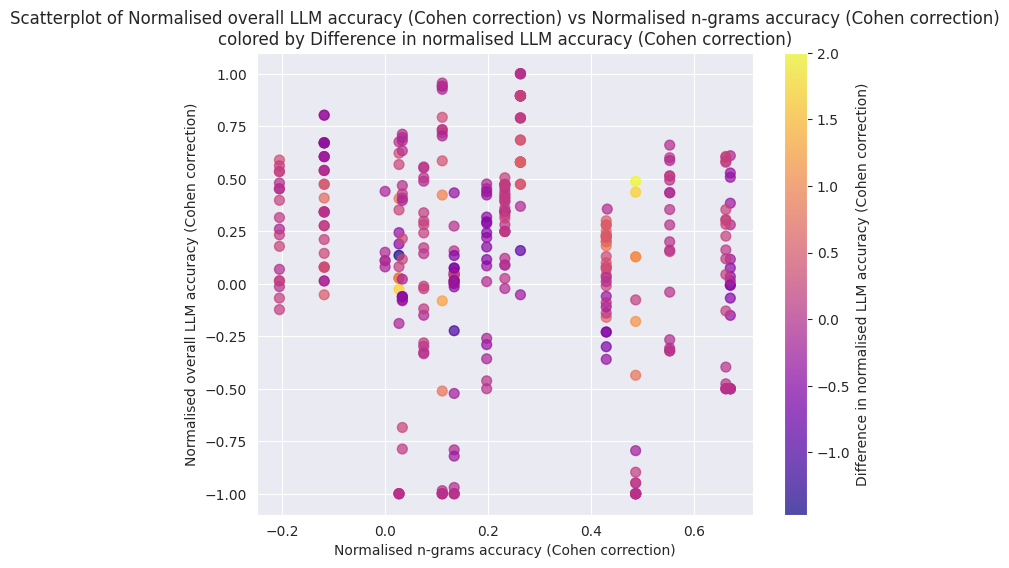

In [461]:
# make a perceptually uniform colormap centered on 0.2
cmap = sns.diverging_palette(220, 20, as_cmap=True)

scatterplot_with_color(stratified_successes_df, "Normalised n-grams accuracy (Cohen correction)", "Normalised overall LLM accuracy (Cohen correction)", "Difference in normalised LLM accuracy (Cohen correction)")

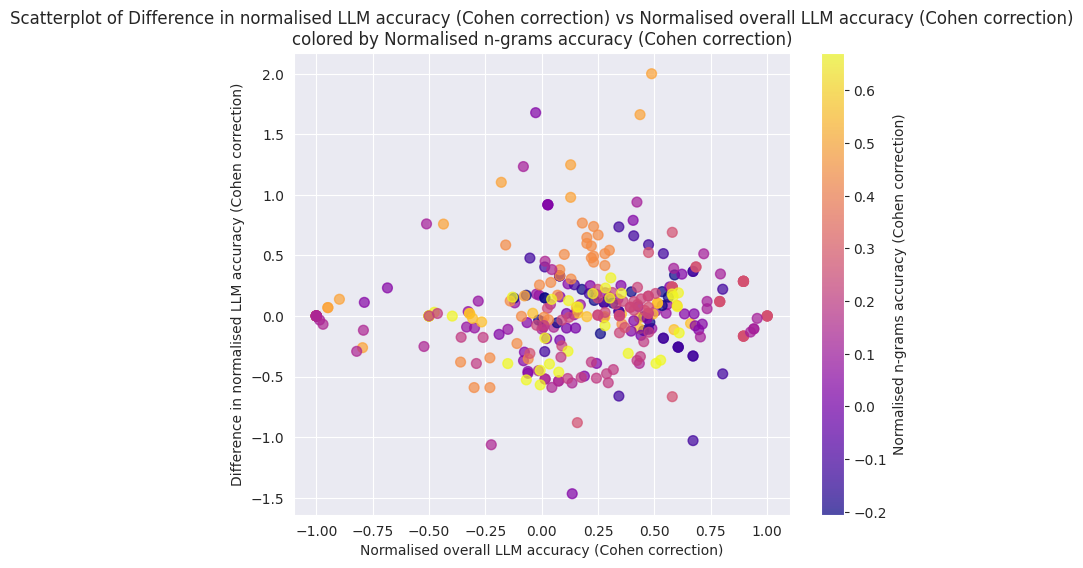

In [462]:
# cmap = sns.diverging_palette(220, 20, as_cmap=True)

scatterplot_with_color(stratified_successes_df, "Normalised overall LLM accuracy (Cohen correction)", "Difference in normalised LLM accuracy (Cohen correction)", "Normalised n-grams accuracy (Cohen correction)")

#### LLM boxplots

Make a boxplot for each LLM, side by side for the successfully and unsuccessfully predicted by n-gram splits.

I need to exclude the datasets where the n-grams have poor predictive power.

The cohen_correction_n_choices column contains the corrected accuracy on the test split of the dataset

In [463]:
best_predictive_method_primal.shape

(19, 10)

In [464]:
threshold = 0.2
# extract the datasets where the cohen_correction_n_choices is <threshold
datasets_to_keep = best_predictive_method_primal[best_predictive_method_primal["cohen_correction_n_choices"] > threshold]["dataset"]
datasets_to_exclude = best_predictive_method_primal[best_predictive_method_primal["cohen_correction_n_choices"] <= threshold]["dataset"]
len(datasets_to_keep)

9

In [465]:
list(datasets_to_exclude)

['CLadder',
 'anli',
 'art',
 'causal_judgment',
 'commonsense_qa_2',
 'formal_fallacies_syllogisms_negation',
 'legalbench_abercrombie',
 'metaphor_boolean',
 'moral_permissibility',
 'wanli']

In [466]:
stratified_successes_df_datasets_to_keep = stratified_successes_df[stratified_successes_df["Dataset"].isin(datasets_to_keep)]
stratified_successes_df_boxplot = stratified_successes_df_datasets_to_keep[["LLM", "Normalised LLM accuracy on successfully predicted split (Cohen correction)", "Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)"]]

In [467]:
stratified_successes_df_boxplot.head()
# meld
stratified_successes_df_boxplot = stratified_successes_df_boxplot.melt(id_vars=["LLM"], var_name="Split", value_name="Normalised LLM accuracy (Cohen correction)")


In [468]:
stratified_successes_df_boxplot.head()

,LLM,Split,Normalised LLM accuracy (Cohen correction)
0,text-davinci-002,Normalised LLM accuracy on successfully predic...,0.336566
1,ada,Normalised LLM accuracy on successfully predic...,-0.313283
2,babbage,Normalised LLM accuracy on successfully predic...,-0.313283
3,curie,Normalised LLM accuracy on successfully predic...,-0.313283
4,davinci,Normalised LLM accuracy on successfully predic...,-0.283208


In [469]:
stratified_successes_df_boxplot.shape

(326, 3)

In [470]:
rename_dict = {'Normalised LLM accuracy on successfully predicted split (Cohen correction)': 'Successfully predicted with n-grams',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)': 'Unsuccessfully predicted with n-grams'}

In [471]:
stratified_successes_df_boxplot["Split"] = stratified_successes_df_boxplot["Split"].replace(rename_dict)

In [472]:
stratified_successes_df_boxplot["LLM"] = stratified_successes_df_boxplot["LLM"].replace(models_dict)

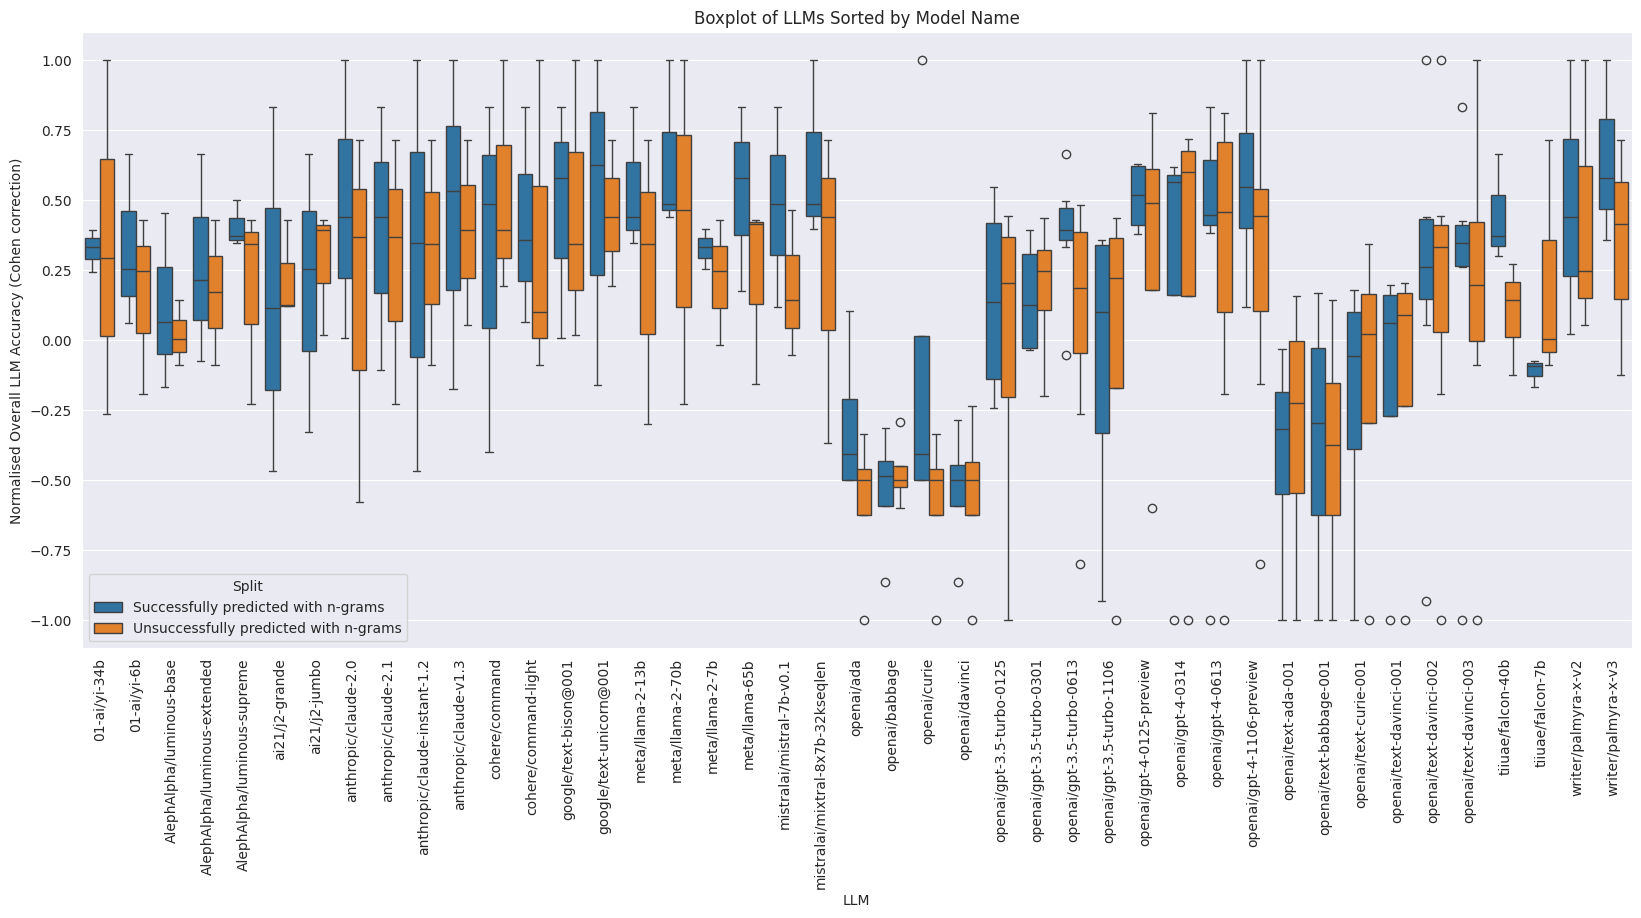

In [473]:
# Sort the LLMs based on the overall accuracy
sorted_llms_by_name = sorted(stratified_successes_df_boxplot['LLM'].unique())

# Create a boxplot of the sorted LLMs
plt.figure(figsize=(20, 8))
sns.boxplot(x='LLM', y="Normalised LLM accuracy (Cohen correction)", data=stratified_successes_df_boxplot, 
            order=sorted_llms_by_name, hue="Split")
plt.xticks(rotation=90)
plt.title('Boxplot of LLMs Sorted by Model Name')
plt.xlabel('LLM')
plt.ylabel('Normalised Overall LLM Accuracy (Cohen correction)')
plt.show()

This is quite interesting, looks like some of the families may rely on shortcuts substantially. 


Do paired t-tests at the family level. 

In [474]:
stratified_successes_df_t_test = stratified_successes_df_datasets_to_keep[["LLM", "Normalised LLM accuracy on successfully predicted split (Cohen correction)", "Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)", "Dataset"]]

In [475]:
# rename LLM using model_dict
stratified_successes_df_t_test["LLM"] = stratified_successes_df_t_test["LLM"].replace(models_dict)

/tmp/ipykernel_35033/581347549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stratified_successes_df_t_test["LLM"] = stratified_successes_df_t_test["LLM"].replace(models_dict)


In [477]:
stratified_successes_df_t_test["LLM_family"] = stratified_successes_df_t_test["LLM"].apply(lambda x: x.split("/")[0])
stratified_successes_df_t_test["LLM_family"].unique()

/tmp/ipykernel_35033/3587602393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stratified_successes_df_t_test["LLM_family"] = stratified_successes_df_t_test["LLM"].apply(lambda x: x.split("/")[0])


array(['openai', '01-ai', 'AlephAlpha', 'ai21', 'anthropic', 'cohere',
       'google', 'meta', 'mistralai', 'tiiuae', 'writer'], dtype=object)

In [478]:
corrected_paired_t_test(stratified_successes_df_t_test, "LLM_family", alternative="greater")

,LLM_family,t_stat,p_value,p_value_corrected,significant
0,openai,2.347232,0.010592,0.058255,False
1,01-ai,0.448783,0.336185,0.528291,False
2,AlephAlpha,1.341371,0.108315,0.198578,False
3,ai21,-0.494341,0.678992,0.681576,False
4,anthropic,1.573859,0.071911,0.158205,False
5,cohere,-0.502213,0.681576,0.681576,False
6,google,0.285104,0.393498,0.541060,False
7,meta,2.890801,0.007342,0.058255,False
8,mistralai,2.499033,0.027277,0.089484,False
9,tiiuae,0.068440,0.474044,0.579387,False


### Aggregated plots, stratified across correctly and uncorrectly predicted splits, without XGBoost
Keep only the features that have the highest validation accuracy for each dataset, and then see if there is an effect on the difference in LLM performance. 

For each dataset, keep the best predictive method and features

In [25]:
primal_performance_df_no_baselines = primal_performance_df[~primal_performance_df["predictive_method"].isin(["most_likely_answer", "random_guess", "xgboost"])]

best_predictive_method_primal = primal_performance_df_no_baselines.groupby(["dataset"]).apply(lambda x: x[x.Accuracy_val == x.Accuracy_val.max()]).reset_index(drop=True)
# if there are more than one entry with the same accuracy for each ["dataset", "features"] combination, then pick the first one; also keep the dataset and features columns
best_predictive_method_primal = best_predictive_method_primal.groupby(["dataset"]).first().reset_index()

Compute Cohen correction for the predictive performance of the simple methods

In [26]:
# add two empty columns to the dataframe: cohen_correction_n_choices and cohen_correction_proportions
best_predictive_method_primal["cohen_correction_n_choices"] = np.nan
# best_predictive_method_primal["cohen_correction_proportions"] = np.nan
# loop over all datasets
for dataset in tqdm(total_list):
    instance, dataset_name, ideal_col_name, group = initialize_instance(dataset)

    # Split the dataset
    train_df, val_df, test_df = instance.train_val_test_split(discard_na_rows=False, rng=np.random.RandomState(42), train_size=0.6, val_size=0.2)

    primal_train_labels = train_df[ideal_col_name]
    primal_test_labels = test_df[ideal_col_name]

    # Encode the labels
    label_encoder = LabelEncoder()
    primal_train_labels_encoded = label_encoder.fit_transform(primal_train_labels)
    primal_test_labels_encoded = label_encoder.transform(test_df[ideal_col_name])

    # extract the indices of the dataframe with that dataset:
    indices = best_predictive_method_primal[best_predictive_method_primal["dataset"] == dataset_name].index
    # loop over those rows:
    for i in indices:
        if best_predictive_method_primal.loc[i, "predictive_method"] in ["most_likely_answer", "random_guess"]:
            continue
        # extract the predictions from the best_predictive_method_primal dataframe
        instance_level_predictions = best_predictive_method_primal.loc[i, "instance_level_predictions_test"]
        # extract the labels
        # compute the random guess
        random_guess_n_choices = 1 / len(primal_test_labels.unique())
        # random_guess_proportion = compute_random_guesses(primal_test_labels_encoded, instance_level_predictions)
        # now compute the Cohen's correction with the two random guess values
        cohen_correction_n_choices = Cohen_correction(best_predictive_method_primal.loc[i, "Accuracy_test"], random_guess_n_choices)
        # cohen_correction_proportion = Cohen_correction(best_predictive_method_per_feature_primal.loc[i, "Accuracy_test"], random_guess_proportion)
        # update the dataframe
        best_predictive_method_primal.loc[i, "cohen_correction_n_choices"] = cohen_correction_n_choices
        # best_predictive_method_primal.loc[i, "cohen_correction_proportions"] = cohen_correction_proportion


  0%|          | 0/19 [00:00<?, ?it/s]

In [27]:
best_predictive_method_primal.columns

Index(['dataset', 'predictive_method', 'features', 'trained_classifier',
       'Accuracy_val', 'Accuracy_test', 'instance_level_predictions_val',
       'instance_level_predictions_test', 'group',
       'cohen_correction_n_choices'],
      dtype='object')

Table with the best features and predictive method

In [28]:
features_labels = {
    'Cohen_1-grams_presence': "1-grams Presence",
    'Cohen_1-grams_presence_gpt2': "1-grams Presence (GPT-2)",
    'Cohen_1-grams_simple_frequency': "1-grams Frequency",
    'Cohen_1-grams_simple_frequency_gpt2': "1-grams Frequency (GPT-2)",
    'Cohen_1-grams_tfidf': "1-grams TF-IDF",
    'Cohen_1-grams_tfidf_gpt2': "1-grams TF-IDF (GPT-2)",
    'Cohen_2-grams_presence': "2-grams Presence",
    'Cohen_2-grams_presence_gpt2': "2-grams Presence (GPT-2)",
    'Cohen_2-grams_simple_frequency': "2-grams Frequency",
    'Cohen_2-grams_simple_frequency_gpt2': "2-grams Frequency (GPT-2)",
    'Cohen_2-grams_tfidf': "2-grams TF-IDF",
    'Cohen_2-grams_tfidf_gpt2': "2-grams TF-IDF (GPT-2)",
    'Cohen_readability_diversity_metrics': "Readability & Diversity Metrics"
}
predictive_method_labels = {
    'logistic_regression_l1_c=1': "Log Reg (L1, C=1)",
    'logistic_regression_l1_c=0.1': "Log Reg (L1, C=0.1)",
    'logistic_regression_l2': "Log Reg (L2, C=1)",
}

In [29]:
best_predictive_method_primal_for_table = best_predictive_method_primal.copy()
best_predictive_method_primal_for_table["features"] = best_predictive_method_primal_for_table["features"].replace(features_labels)
best_predictive_method_primal_for_table["predictive_method"] = best_predictive_method_primal_for_table["predictive_method"].replace(predictive_method_labels)

# make a latex table
print(best_predictive_method_primal_for_table[['dataset', 'predictive_method', 'features']].to_latex(index=False))

\begin{tabular}{lll}
\toprule
                                       dataset &   predictive\_method &                      features \\
\midrule
                                       CLadder &   Log Reg (L1, C=1) &      2-grams\_simple\_frequency \\
                                      ProntoQA &   Log Reg (L1, C=1) &      2-grams\_simple\_frequency \\
                                          anli &   Log Reg (L1, C=1) & readability\_diversity\_metrics \\
                                           art & Log Reg (L1, C=0.1) & readability\_diversity\_metrics \\
                                  babi\_task\_16 &   Log Reg (L1, C=1) &      2-grams\_simple\_frequency \\
                               causal\_judgment & Log Reg (L1, C=0.1) & readability\_diversity\_metrics \\
                              commonsense\_qa\_2 &   Log Reg (L1, C=1) & readability\_diversity\_metrics \\
                             fantasy\_reasoning & Log Reg (L1, C=0.1) &      1-grams\_simple\_frequency \\
  

/tmp/ipykernel_36504/2115429785.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_predictive_method_primal_for_table[['dataset', 'predictive_method', 'features']].to_latex(index=False))


In [30]:
# make ascii table
print(best_predictive_method_primal[['dataset', 'predictive_method', 'features']].to_string(index=False))

                                       dataset            predictive_method                      features
                                       CLadder   logistic_regression_l1_c=1      2-grams_simple_frequency
                                      ProntoQA   logistic_regression_l1_c=1      2-grams_simple_frequency
                                          anli   logistic_regression_l1_c=1 readability_diversity_metrics
                                           art logistic_regression_l1_c=0.1 readability_diversity_metrics
                                  babi_task_16   logistic_regression_l1_c=1      2-grams_simple_frequency
                               causal_judgment logistic_regression_l1_c=0.1 readability_diversity_metrics
                              commonsense_qa_2   logistic_regression_l1_c=1 readability_diversity_metrics
                             fantasy_reasoning logistic_regression_l1_c=0.1      1-grams_simple_frequency
          formal_fallacies_syllogisms_negation

Load the stratified successes file 

In [31]:
stratified_success_file = "results/stratified_successes_no_xgboost.csv"
# load 
stratified_successes_df = load_with_conditions(stratified_success_file)

Loading existing dataframe.


In [32]:
stratified_successes_df.shape

(9724, 6)

In [33]:
print(stratified_successes_df.isna().sum())

llm                             0
dataset                         0
average_success               266
cohen_correction_n_choices    266
on                              0
features                        0
dtype: int64


In [34]:
# drop the rows without na values
stratified_successes_df_na = stratified_successes_df[stratified_successes_df.isna().any(axis=1)]

In [35]:
stratified_successes_df_na.dataset.unique()

array(['legalbench_corporate_lobbying'], dtype=object)

That dataset has some na values because there was perfect predictability with n-grams -> no way to compute the performance of LLMs on the unsuccessfully predicted instances.

I need to discard this from the analysis then

In [36]:
stratified_successes_df = stratified_successes_df[stratified_successes_df["dataset"] != "legalbench_corporate_lobbying"]

In [37]:
stratified_successes_df.columns

Index(['llm', 'dataset', 'average_success', 'cohen_correction_n_choices', 'on',
       'features'],
      dtype='object')

Compute the difference of LLM performance in the cases successfully and unsuccessfully predicted by the simple method

In [38]:
stratified_successes_df = stratified_successes_df.pivot_table(index=["dataset", "llm", "features"], columns="on", values="cohen_correction_n_choices")
stratified_successes_df = stratified_successes_df.reset_index()
stratified_successes_df["cohen_correction_difference"] = stratified_successes_df["successfully_predicted"] - stratified_successes_df["unsuccessfully_predicted"]
stratified_successes_df.head()

on,dataset,llm,features,successfully_predicted,unsuccessfully_predicted,cohen_correction_difference
0,CLadder,davinci,1-grams_presence,0.080119,-0.015544,0.095663
1,CLadder,davinci,1-grams_presence_gpt2,0.082917,-0.017903,0.100820
2,CLadder,davinci,1-grams_simple_frequency,0.080119,-0.015544,0.095663
3,CLadder,davinci,1-grams_simple_frequency_gpt2,0.082917,-0.017903,0.100820
4,CLadder,davinci,1-grams_tfidf,0.105209,-0.042289,0.147498


In [39]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features', 'successfully_predicted',
       'unsuccessfully_predicted', 'cohen_correction_difference'],
      dtype='object', name='on')

In [40]:
# stratified_successes_df.drop(["successfully_predicted", "unsuccessfully_predicted"], axis=1, inplace=True)
stratified_successes_df = stratified_successes_df.rename(columns={"cohen_correction_difference": "Difference in normalised LLM accuracy (Cohen correction)", "successfully_predicted": "Normalised LLM accuracy on successfully predicted split (Cohen correction)", "unsuccessfully_predicted": "Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)"})

In [41]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)'],
      dtype='object', name='on')

In [42]:
stratified_successes_df.shape

(4472, 6)

For each dataset, I should only keep the rows where the features are the best one, ie those in the best_predictive_method_primal dataframe 
(notice that this the results in stratified_successes_df were already computed with the best predictive method)

The following cell merges the two dataframes and thus selects the best features for the stratified successes df.

In [43]:
stratified_successes_df = stratified_successes_df.merge(best_predictive_method_primal, on=["dataset", "features"])

In [44]:
stratified_successes_df.shape

(344, 14)

In [45]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)',
       'predictive_method', 'trained_classifier', 'Accuracy_val',
       'Accuracy_test', 'instance_level_predictions_val',
       'instance_level_predictions_test', 'group',
       'cohen_correction_n_choices'],
      dtype='object')

In [46]:
stratified_successes_df = stratified_successes_df.drop(columns=["Accuracy_val", "Accuracy_test", "instance_level_predictions_test", "group", "trained_classifier", "instance_level_predictions_val"])

In [47]:
stratified_successes_df.columns

Index(['dataset', 'llm', 'features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)',
       'predictive_method', 'cohen_correction_n_choices'],
      dtype='object')

In [48]:
rename_dict = {
    'llm': 'LLM',
    'dataset': 'Dataset',
    'on': 'on',
    'features': 'Features',
    'cohen_correction_n_choices': 'Normalised n-grams accuracy (Cohen correction)',
    'successfully_predicted': 'Successfully predicted',
}

In [49]:
stratified_successes_df = stratified_successes_df.rename(columns=rename_dict)

In [50]:
stratified_successes_df.head()

,Dataset,LLM,Features,Normalised LLM accuracy on successfully predicted split (Cohen correction),Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction),Difference in normalised LLM accuracy (Cohen correction),predictive_method,Normalised n-grams accuracy (Cohen correction)
0,CLadder,davinci,2-grams_simple_frequency,0.071921,-0.005208,0.077130,logistic_regression_l1_c=1,0.014021
1,CLadder,gpt-3.5-turbo-0613,2-grams_simple_frequency,-0.004926,0.023438,-0.028364,logistic_regression_l1_c=1,0.014021
2,CLadder,gpt-4-1106-preview,2-grams_simple_frequency,0.280788,0.265625,0.015163,logistic_regression_l1_c=1,0.014021
3,CLadder,llama007,2-grams_simple_frequency,-0.050246,0.067708,-0.117955,logistic_regression_l1_c=1,0.014021
4,CLadder,text-davinci-001,2-grams_simple_frequency,-0.034483,0.049479,-0.083962,logistic_regression_l1_c=1,0.014021


Merge with the overall LLM accuracy dataframe:

In [51]:
stratified_successes_df = stratified_successes_df.merge(overall_LLM_accuracy_df, on=["LLM", "Dataset"])

In [52]:
stratified_successes_df.head()

,Dataset,LLM,Features,Normalised LLM accuracy on successfully predicted split (Cohen correction),Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction),Difference in normalised LLM accuracy (Cohen correction),predictive_method,Normalised n-grams accuracy (Cohen correction),Overall LLM accuracy,Normalised overall LLM accuracy (Cohen correction)
0,CLadder,davinci,2-grams_simple_frequency,0.071921,-0.005208,0.077130,logistic_regression_l1_c=1,0.014021,0.519349,0.038699
1,CLadder,gpt-3.5-turbo-0613,2-grams_simple_frequency,-0.004926,0.023438,-0.028364,logistic_regression_l1_c=1,0.014021,0.503646,0.007291
2,CLadder,gpt-4-1106-preview,2-grams_simple_frequency,0.280788,0.265625,0.015163,logistic_regression_l1_c=1,0.014021,0.637128,0.274257
3,CLadder,llama007,2-grams_simple_frequency,-0.050246,0.067708,-0.117955,logistic_regression_l1_c=1,0.014021,0.500280,0.000561
4,CLadder,text-davinci-001,2-grams_simple_frequency,-0.034483,0.049479,-0.083962,logistic_regression_l1_c=1,0.014021,0.500841,0.001683


In [53]:
stratified_successes_df.columns

Index(['Dataset', 'LLM', 'Features',
       'Normalised LLM accuracy on successfully predicted split (Cohen correction)',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)',
       'Difference in normalised LLM accuracy (Cohen correction)',
       'predictive_method', 'Normalised n-grams accuracy (Cohen correction)',
       'Overall LLM accuracy',
       'Normalised overall LLM accuracy (Cohen correction)'],
      dtype='object')

In [54]:
len(stratified_successes_df["Normalised overall LLM accuracy (Cohen correction)"].unique())

234

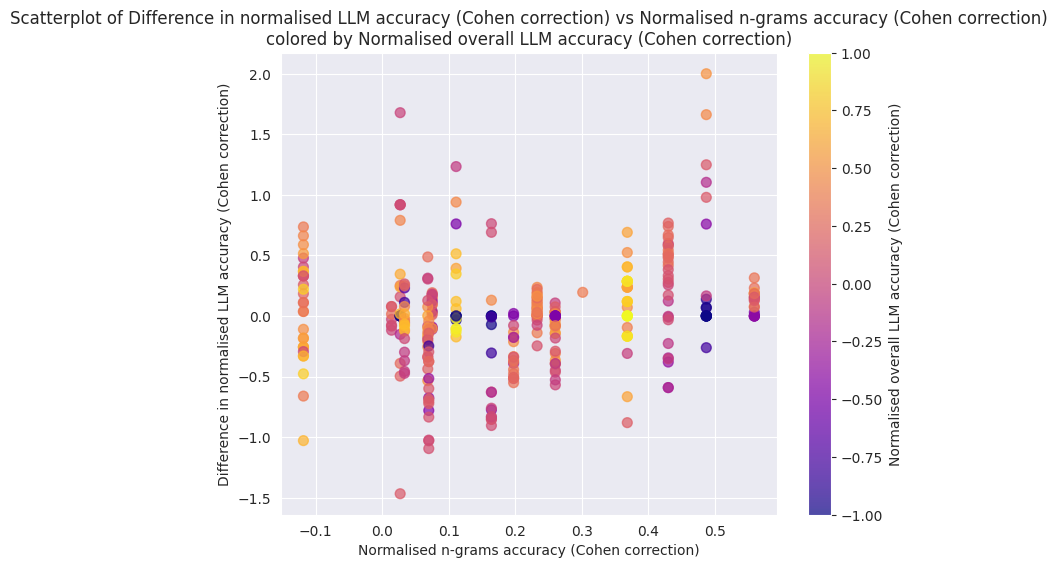

In [757]:
#cmap = sns.diverging_palette(220, 20, as_cmap=True)

scatterplot_with_color(stratified_successes_df, "Normalised n-grams accuracy (Cohen correction)", "Difference in normalised LLM accuracy (Cohen correction)", "Normalised overall LLM accuracy (Cohen correction)")#, cmap=cmap)

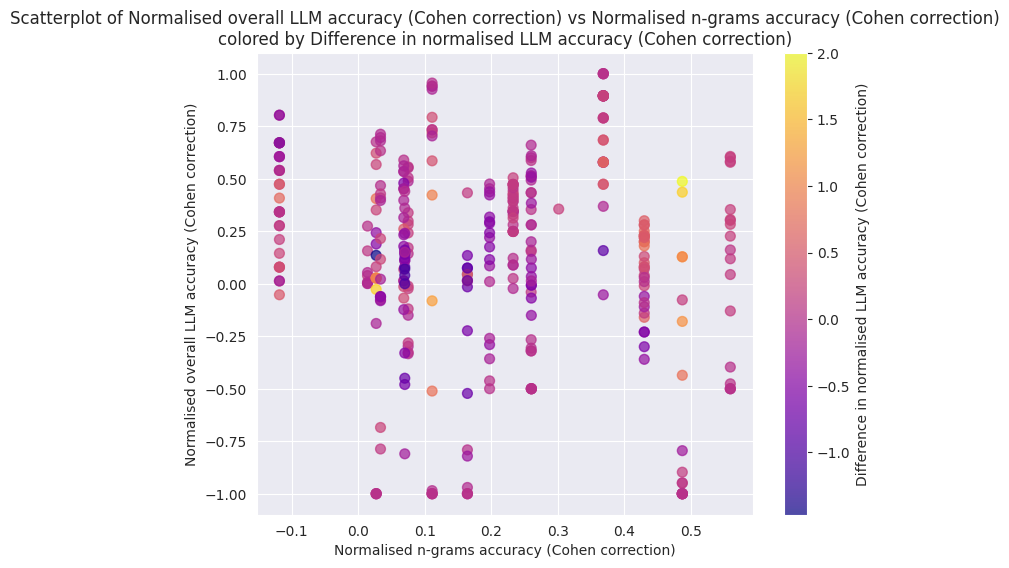

In [758]:
scatterplot_with_color(stratified_successes_df, "Normalised n-grams accuracy (Cohen correction)", "Normalised overall LLM accuracy (Cohen correction)", "Difference in normalised LLM accuracy (Cohen correction)")

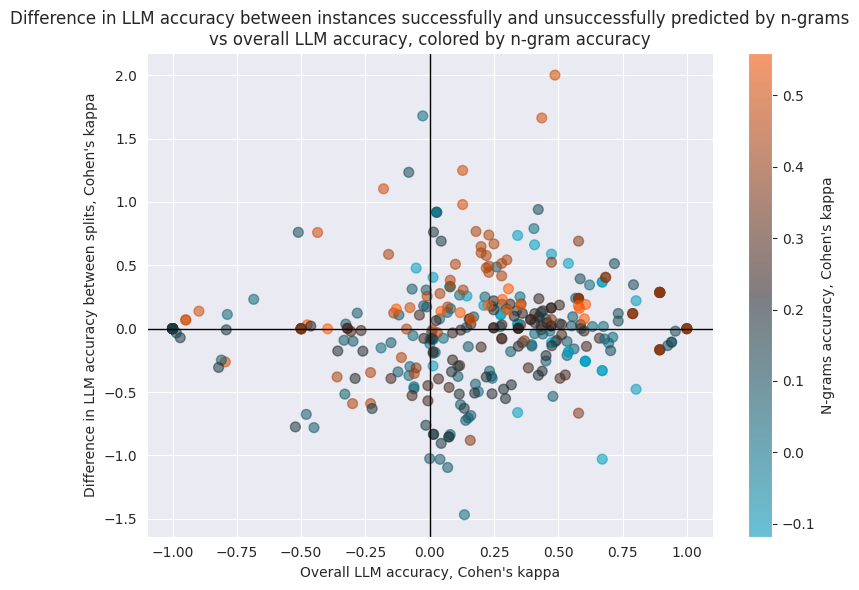

In [788]:
cmap = sns.diverging_palette(220, 20, as_cmap=True, center='dark', s=100, l=60, sep=1)
# cmap="winter"

alpha=0.55

x_column = "Normalised overall LLM accuracy (Cohen correction)"
y_column = "Difference in normalised LLM accuracy (Cohen correction)"
color_column = "Normalised n-grams accuracy (Cohen correction)"

plt.figure(figsize=(8, 6))
scatter = plt.scatter(stratified_successes_df[x_column], stratified_successes_df[y_column], c=stratified_successes_df[color_column], cmap=cmap, s=50, alpha=alpha, marker="o")

# remove the grid
# plt.grid(False)
# put horizontal and vertical lines at 0
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)

plt.title(f'Difference in LLM accuracy between instances successfully and unsuccessfully predicted by n-grams\nvs overall LLM accuracy, colored by n-gram accuracy')
plt.ylabel("Difference in LLM accuracy between splits, Cohen's kappa")
plt.xlabel("Overall LLM accuracy, Cohen's kappa")
plt.colorbar(scatter, label="N-grams accuracy, Cohen's kappa")

# save with tight layout
plt.tight_layout()
plt.savefig("fig/scatterplot.pdf")
plt.savefig("fig/scatterplot.png")

#### LLM boxplots

Make a boxplot for each LLM, side by side for the successfully and unsuccessfully predicted by n-gram splits.

I need to exclude the datasets where the n-grams have poor predictive power.

The cohen_correction_n_choices column contains the corrected accuracy on the test split of the dataset

In [56]:
threshold = 0.2
# extract the datasets where the cohen_correction_n_choices is <threshold
datasets_to_keep = best_predictive_method_primal[best_predictive_method_primal["cohen_correction_n_choices"] > threshold]["dataset"]
datasets_to_exclude = best_predictive_method_primal[best_predictive_method_primal["cohen_correction_n_choices"] <= threshold]["dataset"]
len(datasets_to_keep)

9

In [57]:
list(datasets_to_exclude)

['CLadder',
 'anli',
 'art',
 'causal_judgment',
 'commonsense_qa_2',
 'formal_fallacies_syllogisms_negation',
 'legalbench_abercrombie',
 'metaphor_boolean',
 'moral_permissibility',
 'wanli']

In [58]:
stratified_successes_df_datasets_to_keep = stratified_successes_df[stratified_successes_df["Dataset"].isin(datasets_to_keep)]
stratified_successes_df_boxplot = stratified_successes_df_datasets_to_keep[["LLM", "Normalised LLM accuracy on successfully predicted split (Cohen correction)", "Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)"]]

In [59]:
stratified_successes_df_boxplot.head()
# meld
stratified_successes_df_boxplot = stratified_successes_df_boxplot.melt(id_vars=["LLM"], var_name="Split", value_name="Normalised LLM accuracy (Cohen correction)")

In [60]:
stratified_successes_df_boxplot.head()

,LLM,Split,Normalised LLM accuracy (Cohen correction)
0,text-davinci-002,Normalised LLM accuracy on successfully predic...,0.423693
1,ada,Normalised LLM accuracy on successfully predic...,-0.318681
2,babbage,Normalised LLM accuracy on successfully predic...,-0.318681
3,curie,Normalised LLM accuracy on successfully predic...,-0.318681
4,davinci,Normalised LLM accuracy on successfully predic...,-0.274725


In [61]:
stratified_successes_df_boxplot.shape

(326, 3)

In [62]:
rename_dict = {'Normalised LLM accuracy on successfully predicted split (Cohen correction)': 'Successfully predicted with n-grams',
       'Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)': 'Unsuccessfully predicted with n-grams'}

In [63]:
stratified_successes_df_boxplot["Split"] = stratified_successes_df_boxplot["Split"].replace(rename_dict)

In [64]:
len(stratified_successes_df_boxplot["LLM"].unique())

43

In [65]:
stratified_successes_df_boxplot["LLM"] = stratified_successes_df_boxplot["LLM"].replace(models_dict)

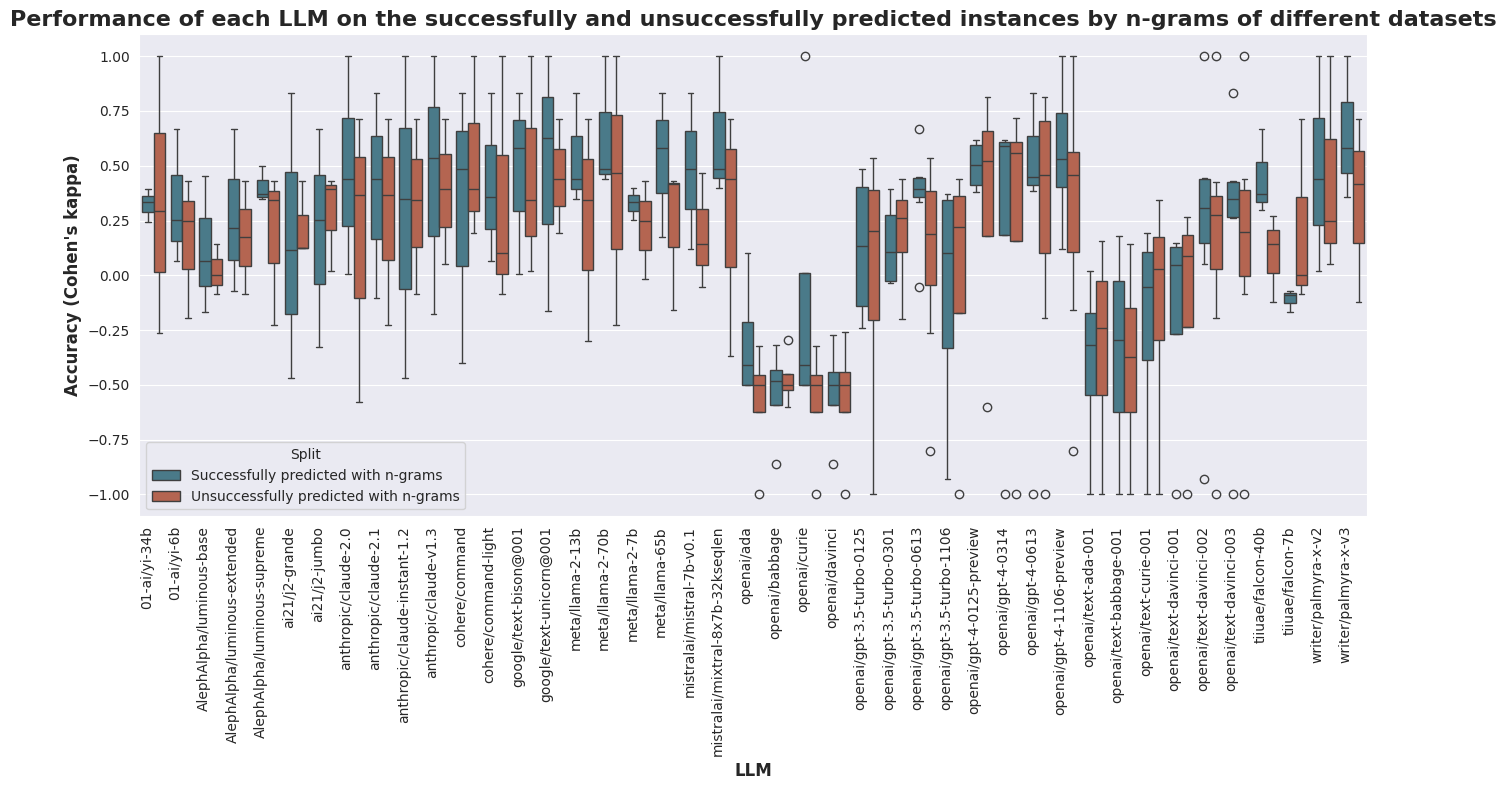

In [66]:
alpha = 0.9
# Sort the LLMs based on the overall accuracy
sorted_llms_by_name = sorted(stratified_successes_df_boxplot['LLM'].unique())

# Create a boxplot of the sorted LLMs
plt.figure(figsize=(20*2/3, 8))

# use the extremes of this colormap as colors:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# extract the two extreme values
cmap_min = cmap(-50)#np.inf)
cmap_max = cmap(250)#np.inf)
# convert to lists
cmap_min = list(cmap_min)
cmap_max = list(cmap_max)
cmap_min[-1] = alpha
cmap_max[-1] = alpha

sns.boxplot(x='LLM', y="Normalised LLM accuracy (Cohen correction)", data=stratified_successes_df_boxplot, 
            order=sorted_llms_by_name, hue="Split", palette={'Successfully predicted with n-grams': cmap_min, 'Unsuccessfully predicted with n-grams': cmap_max})
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
    
title = 'Performance of each LLM on the successfully and unsuccessfully predicted instances by n-grams of different datasets'
plt.title(title, fontsize=16, fontweight='bold')    
plt.xlabel('LLM', fontsize=12, fontweight='bold')
plt.ylabel("Accuracy (Cohen's kappa)", fontsize=12, fontweight='bold')
plt.tight_layout()
# save
plt.savefig("fig/llm_boxplot.png")
plt.savefig("fig/llm_boxplot.pdf")
plt.show()

This is quite interesting, looks like some of the families may rely on shortcuts substantially. This plot groups by LLM, while the scatterplots I did before do not. On the converse, this one does not display the performance of the n-gram classifier and the overall accuracy of the LLM (though that can be somehow induced by the two boxplots).



#### t-tests


In [67]:
stratified_successes_df_t_test = stratified_successes_df_datasets_to_keep[["LLM", "Normalised LLM accuracy on successfully predicted split (Cohen correction)", "Normalised LLM accuracy on unsuccessfully predicted split (Cohen correction)", "Dataset"]]

In [68]:
# rename LLM using model_dict
stratified_successes_df_t_test["LLM"] = stratified_successes_df_t_test["LLM"].replace(models_dict)

/tmp/ipykernel_36504/581347549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stratified_successes_df_t_test["LLM"] = stratified_successes_df_t_test["LLM"].replace(models_dict)


In [74]:
llm_model_families = {
    'openai/ada': 'OpenAI/GPT-3-base',
    'openai/babbage': 'OpenAI/GPT-3-base',
    'openai/curie': 'OpenAI/GPT-3-base',
    'openai/davinci': 'OpenAI/GPT-3-base',
    'openai/text-ada-001': 'OpenAI/GPT-3-instruct',
    'openai/text-babbage-001': 'OpenAI/GPT-3-instruct',
    'openai/text-curie-001': 'OpenAI/GPT-3-instruct',
    'openai/text-davinci-001': 'OpenAI/GPT-3-instruct',
    'openai/text-davinci-002': 'OpenAI/GPT-3.5',
    'openai/text-davinci-003': 'OpenAI/GPT-3.5',
    'openai/gpt-3.5-turbo-0125': 'OpenAI/GPT-3.5',
    'openai/gpt-3.5-turbo-0301': 'OpenAI/GPT-3.5',
    'openai/gpt-3.5-turbo-0613': 'OpenAI/GPT-3.5',
    'openai/gpt-3.5-turbo-1106': 'OpenAI/GPT-3.5',
    'openai/gpt-4-0125-preview': 'OpenAI/GPT-4',
    'openai/gpt-4-0314': 'OpenAI/GPT-4',
    'openai/gpt-4-0613': 'OpenAI/GPT-4',
    'openai/gpt-4-1106-preview': 'OpenAI/GPT-4',
}

def model_family(llm):
    if llm.startswith("openai"):
        family = llm_model_families[llm]
    else:
        family = llm.split("/")[0]
    return family

In [75]:
stratified_successes_df_t_test["LLM_family"] = stratified_successes_df_t_test["LLM"].apply(model_family)
stratified_successes_df_t_test["LLM_family"].unique()

/tmp/ipykernel_36504/2486894685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stratified_successes_df_t_test["LLM_family"] = stratified_successes_df_t_test["LLM"].apply(model_family)


array(['OpenAI/GPT-3.5', 'OpenAI/GPT-3-base', 'OpenAI/GPT-4',
       'OpenAI/GPT-3-instruct', '01-ai', 'AlephAlpha', 'ai21',
       'anthropic', 'cohere', 'google', 'meta', 'mistralai', 'tiiuae',
       'writer'], dtype=object)

In [82]:
res_df_family = corrected_paired_t_test(stratified_successes_df_t_test, "LLM_family", alternative="greater")
res_df_family

,LLM_family,t_stat,p_value,p_value_corrected,significant
0,OpenAI/GPT-3.5,1.607700,0.058714,0.172833,False
1,OpenAI/GPT-3-base,1.322423,0.102919,0.189552,False
2,OpenAI/GPT-4,1.501388,0.074071,0.172833,False
3,OpenAI/GPT-3-instruct,-0.807804,0.784086,0.784086,False
4,01-ai,0.448783,0.336185,0.522954,False
5,AlephAlpha,1.341371,0.108315,0.189552,False
6,ai21,-0.494341,0.678992,0.734005,False
7,anthropic,1.573859,0.071911,0.172833,False
8,cohere,-0.502213,0.681576,0.734005,False
9,google,0.285104,0.393498,0.550898,False


Count the number of LLMs per each model family:


In [83]:
llm_family_counts = stratified_successes_df_t_test.groupby("LLM_family")["LLM"].nunique()

In [84]:
llm_family_counts = llm_family_counts.rename("Number of LLMs")

In [85]:
# merge that with the res_df
res_df_family = res_df_family.merge(llm_family_counts, left_on="LLM_family", right_index=True)
res_df_family[["LLM_family", 'p_value', 'p_value_corrected', 'Number of LLMs']]

,LLM_family,p_value,p_value_corrected,Number of LLMs
0,OpenAI/GPT-3.5,0.058714,0.172833,6
1,OpenAI/GPT-3-base,0.102919,0.189552,4
2,OpenAI/GPT-4,0.074071,0.172833,4
3,OpenAI/GPT-3-instruct,0.784086,0.784086,4
4,01-ai,0.336185,0.522954,2
5,AlephAlpha,0.108315,0.189552,3
6,ai21,0.678992,0.734005,2
7,anthropic,0.071911,0.172833,4
8,cohere,0.681576,0.734005,2
9,google,0.393498,0.550898,2


In [80]:
# make now a latex table considering the LLM_famliy, p_value and p_value_corrected columns
print(res_df_family[['LLM_family', 'p_value', 'p_value_corrected', 'Number of LLMs']].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
           LLM\_family &  p\_value &  p\_value\_corrected &  Number of LLMs \\
\midrule
       OpenAI/GPT-3.5 & 0.058714 &           0.172833 &               6 \\
    OpenAI/GPT-3-base & 0.102919 &           0.189552 &               4 \\
         OpenAI/GPT-4 & 0.074071 &           0.172833 &               4 \\
OpenAI/GPT-3-instruct & 0.784086 &           0.784086 &               4 \\
                01-ai & 0.336185 &           0.522954 &               2 \\
           AlephAlpha & 0.108315 &           0.189552 &               3 \\
                 ai21 & 0.678992 &           0.734005 &               2 \\
            anthropic & 0.071911 &           0.172833 &               4 \\
               cohere & 0.681576 &           0.734005 &               2 \\
               google & 0.393498 &           0.550898 &               2 \\
                 meta & 0.007342 &           0.102793 &               4 \\
            mistralai & 0.027277 &           0.151851 & 

/tmp/ipykernel_36504/1577212733.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res_df_family[['LLM_family', 'p_value', 'p_value_corrected', 'Number of LLMs']].to_latex(index=False))
